In [2]:
!pip install torch pandas numpy scikit-learn
!pip install ta

  Using cached torch-2.7.1-cp310-cp310-manylinux_2_28_x86_64.whl (821.2 MB)
  Using cached scikit_learn-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
  Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.85-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl (19.7 MB)
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (56.3 MB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (393.1 MB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (897 kB)
  Using cached triton-3.3.1-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (155.6 MB)
  Using cached nvidia_nvtx_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89 kB)
  Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta

In [4]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available! Using:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU not available. Using CPU instead.")


✅ GPU is available! Using: NVIDIA GeForce RTX 3050 Laptop GPU


In [24]:
# def load_data(csv_file):
#     """
#     Loads the CSV file into a Pandas DataFrame.
#     Ensures it is sorted by date ascending.
#     """
#     df = pd.read_csv(csv_file)
#     df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
#     df.sort_values(by='Gmt time', inplace=True)

#     # Reset index to ensure a clean index
#     df.reset_index(drop=True, inplace=True)
#     return df
# wrong as the dataset i have is tab seperated not comma separated

In [25]:
def load_data(csv_file):
    """
    Loads a tab-separated CSV file into a DataFrame and parses datetime.
    """
    df = pd.read_csv(csv_file, delimiter='\t')  # 👈 fix: tab delimiter
    df.columns = df.columns.str.strip()  # Clean up header

    if 'Gmt time' not in df.columns:
        raise ValueError("Expected column 'Gmt time' not found. Check the CSV formatting.")

    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df.sort_values(by='Gmt time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


checking the problem with loading dataset 

In [21]:
import pandas as pd

csv_file = "../Output/formatted_data_1h/AAPL_1h_data.csv"
df = pd.read_csv(csv_file)

print("Actual column names in your CSV:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())


Actual column names in your CSV:
['Gmt time\tOpen\tHigh\tLow\tClose\tVolume']

First 5 rows:
            Gmt time\tOpen\tHigh\tLow\tClose\tVolume
0  01.08.2023 13:30:00.000\t196.235\t196.73\t195....
1  01.08.2023 14:30:00.000\t195.48\t196.17999\t19...
2  01.08.2023 15:30:00.000\t196.11\t196.145\t195....
3  01.08.2023 16:30:00.000\t195.48\t196.03999\t19...
4  01.08.2023 17:30:00.000\t195.735\t196.2701\t19...


In [23]:
csv_file = "../Output/formatted_data_1h/AAPL_1h_data.csv"  # Path to your Forex data file
df = load_data(csv_file)

In [6]:
def add_technical_indicators(df):
    """
    Adds some sample technical indicators using the `ta` library.
    Adjust the window periods and indicators to your liking.
    """

    # RSI
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    # Moving Average Slope
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()

    # Fill any NaNs from indicator calculations
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

In [7]:
def select_and_scale_features(df, feature_cols=None):
    """
    Given a DataFrame, selects the relevant columns and applies MinMax scaling.
    Returns the scaled array, the fitted scaler (for inversing later), and the list of columns used.
    """
    if feature_cols is None:
        # default feature set: O,H,L,C and a few indicators
        feature_cols = ['Open', 'High', 'Low', 'Close',
                        'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']

    data = df[feature_cols].values  # shape: (num_samples, num_features)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols

In [8]:
class StockDataset(Dataset):
    def __init__(self, data, seq_length=60, prediction_length=1, feature_dim=4, target_column_idx=3):
        """
        data: numpy array of shape [num_samples, num_features]
        seq_length: how many timesteps in the input sequence
        prediction_length: how many future steps we want to predict
        feature_dim: total number of features in data (for dimension checking)
        target_column_idx: which column to use as the target (e.g., close=3)
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx

    def __len__(self):
        # The maximum starting index is total_length - seq_length - prediction_length
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        # Input sequence
        x = self.data[idx : idx + self.seq_length]
        # Future price(s)
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [9]:
# [Input: (B, 30, 9)]
#          |
#      [Linear: 9 → 64]
#          |
# [+Positional Embedding (1, 30, 64)]
#          |
#      [Transformer Encoder]
#      (2 Layers, 8 Heads, FF=256)
#          |
# [Output Linear: 64 → 1]
#          |
# [Predictions: (B, 30, 1)


class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        feature_size=9,
        num_layers=2,
        d_model=64,
        nhead=8,
        dim_feedforward=256,
        dropout=0.1,
        seq_length=30,
        prediction_length=1
    ):
        super(TimeSeriesTransformer, self).__init__()

        # We'll embed each feature vector (feature_size) into a d_model-sized vector
        self.input_fc = nn.Linear(feature_size, d_model)

        # Positional Encoding (simple learnable or sinusoidal). We'll do a learnable here:
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_length, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu"
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final output: we want to forecast `prediction_length` steps for 1 dimension (Close price).
        # If you want multi-step and multi-dimensional, adjust accordingly.
        self.fc_out = nn.Linear(d_model, prediction_length)

    def forward(self, src):
        """
        src shape: [batch_size, seq_length, feature_size]
        """
        batch_size, seq_len, _ = src.shape

        # First project features into d_model
        src = self.input_fc(src)  # -> [batch_size, seq_length, d_model]

        # Add positional embedding
        # pos_embedding -> [1, seq_length, d_model], so broadcast along batch dimension
        src = src + self.pos_embedding[:, :seq_len, :]

        # Transformer expects shape: [sequence_length, batch_size, d_model]
        src = src.permute(1, 0, 2)  # -> [seq_length, batch_size, d_model]

        # Pass through the transformer
        encoded = self.transformer_encoder(src)  # [seq_length, batch_size, d_model]

        # We only want the output at the last time step for forecasting the future
        last_step = encoded[-1, :, :]  # [batch_size, d_model]

        out = self.fc_out(last_step)  # [batch_size, prediction_length]
        return out

In [12]:
def train_transformer_model(
    model,
    train_loader,
    val_loader=None,
    lr=1e-3,
    epochs=20,
    device='gpu'
):
    criterion = nn.MSELoss()  # For regression on price
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)  # output shape: [batch_size, prediction_length]
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        mean_train_loss = np.mean(train_losses)

        if val_loader is not None:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    output_val = model(x_val)
                    loss_val = criterion(output_val, y_val)
                    val_losses.append(loss_val.item())
            mean_val_loss = np.mean(val_losses)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")
        else:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {mean_train_loss:.6f}")

    return model

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, test_loader, scaler, feature_cols, target_col_idx,
                   window_width=10, start_index=0, pred_length=1, device='cpu'):
    """
    Evaluates the model on test data and compares predictions with actual prices.
    Plots real vs. predicted values within a given window width and starting index.

    Parameters:
        model: Trained PyTorch model.
        test_loader: DataLoader for test data.
        scaler: MinMaxScaler (used to inverse transform predictions and real values).
        feature_cols: List of feature column names.
        target_col_idx: Index of the "Close" price in feature columns.
        window_width: Number of points to plot for real vs. predicted prices.
        start_index: The index in the test dataset from which to start plotting.
        pred_length: Number of future values predicted by the model.
        device: 'cpu' or 'cuda' for model inference.
    """
    model.eval()
    real_prices = []
    predicted_prices = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)

            # Get model predictions
            predictions = model(x_batch).cpu().numpy()  # shape: [batch_size, pred_length]
            y_batch = y_batch.cpu().numpy()  # shape: [batch_size, pred_length]

            for i in range(len(predictions)):
                # Create dummy inputs for inverse scaling
                dummy_pred = np.zeros((pred_length, len(feature_cols)))
                dummy_pred[:, target_col_idx] = predictions[i]  # Assign predicted future prices

                dummy_real = np.zeros((pred_length, len(feature_cols)))
                dummy_real[:, target_col_idx] = y_batch[i]  # Assign real future prices

                # Inverse transform both predicted and actual prices
                pred_inversed = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
                real_inversed = scaler.inverse_transform(dummy_real)[:, target_col_idx]

                # Store values
                predicted_prices.extend(pred_inversed)
                real_prices.extend(real_inversed)

    # Convert lists to numpy arrays
    real_prices = np.array(real_prices).flatten()
    predicted_prices = np.array(predicted_prices).flatten()

    # -------------------------
    # Compute Accuracy Metrics
    # -------------------------
    mse = np.mean((real_prices - predicted_prices) ** 2)
    mae = np.mean(np.abs(real_prices - predicted_prices))

    print(f"Model Evaluation:\n  - Mean Squared Error (MSE): {mse:.4f}")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")

    # -------------------------
    # Adjust Start Index and Window Width for Plot
    # -------------------------
    if start_index < 0 or start_index >= len(real_prices):
        print(f"Warning: start_index {start_index} is out of bounds. Using 0 instead.")
        start_index = 0

    end_index = min(start_index + window_width * pred_length, len(real_prices))  # Adjust for multi-step forecasts

    # -------------------------
    # Plot Real vs. Predicted Prices
    # -------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), real_prices[start_index:end_index],
             label="Real Close Prices", linestyle="dashed", marker='o')
    plt.plot(range(start_index, end_index), predicted_prices[start_index:end_index],
             label="Predicted Close Prices", linestyle="-", marker='x')
    plt.title(f"Real vs. Predicted Close Prices (From index {start_index}, {window_width} Windows, {pred_length} Steps Each)")
    plt.xlabel("Time Steps")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

In [27]:
# -------------------------
# 1. Load and Prepare Data
# -------------------------
csv_file = "../Output/formatted_data_1h/AAPL_1h_data.csv"  # Path to your Forex data file
df = load_data(csv_file)

# Add indicators
df = add_technical_indicators(df)

# Select features and scale
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index('Close')

# -------------------------
# 2. Create Dataset & Dataloaders
# -------------------------
seq_length = 30
pred_length = 1  # Forecast next 1 candle (adjust for 3 or 5 if needed)

dataset = StockDataset(data_scaled, seq_length, pred_length, len(feature_cols), target_col_idx)

# Train/Validation/Test Split (80% train, 10% val, 10% test)
train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - val_size

# !!! don't use this !!!! train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
# Perform sequential splitting (without shuffling)
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------
# 3. Create and Train Transformer Model
# -------------------------
model = TimeSeriesTransformer(
    feature_size=len(feature_cols),
    num_layers=2,
    d_model=64,
    nhead=8,
    dim_feedforward=256,
    dropout=0.1,
    seq_length=seq_length,
    prediction_length=pred_length
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_transformer_model(model, train_loader, val_loader, lr=1e-3, epochs=10, device=device)

/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/10], Train Loss: 0.035765, Val Loss: 0.006098
Epoch [2/10], Train Loss: 0.004437, Val Loss: 0.004398
Epoch [3/10], Train Loss: 0.003004, Val Loss: 0.005807
Epoch [4/10], Train Loss: 0.002388, Val Loss: 0.002520
Epoch [5/10], Train Loss: 0.001752, Val Loss: 0.003249
Epoch [6/10], Train Loss: 0.001506, Val Loss: 0.002594
Epoch [7/10], Train Loss: 0.001182, Val Loss: 0.003455
Epoch [8/10], Train Loss: 0.001029, Val Loss: 0.002041
Epoch [9/10], Train Loss: 0.001063, Val Loss: 0.002568
Epoch [10/10], Train Loss: 0.000917, Val Loss: 0.001253


Model Evaluation:
  - Mean Squared Error (MSE): 2.2543
  - Mean Absolute Error (MAE): 0.9829


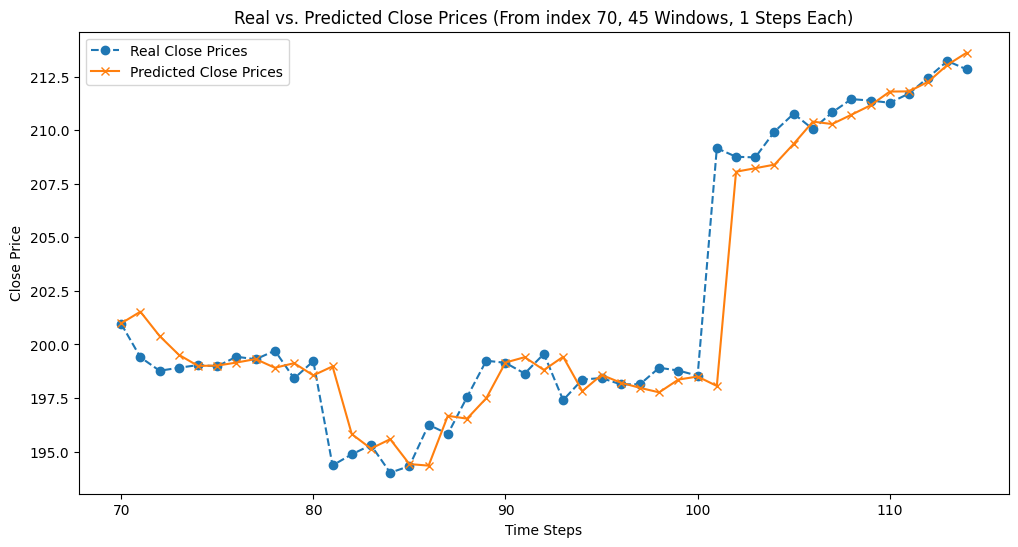

In [28]:
# -------------------------
# 4. Evaluate and Plot Results
# -------------------------
evaluate_model(trained_model, test_loader, scaler, feature_cols, target_col_idx,
               window_width=45, start_index=70, pred_length=1, device=device)

In [32]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Subset
import torch

# CONFIG
DATA_DIR = "../Output/formatted_data_1h"
EPOCHS = 5             # Lowered for safety
BATCH_SIZE = 32
SEQ_LENGTH = 30
PRED_LENGTH = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LIMIT_FILES = None        # Process only a few files to avoid overload

# Load and clean CSV
def safe_load_data(csv_file):
    try:
        df = pd.read_csv(csv_file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Gmt time' not in df.columns:
            print(f"[SKIP] '{csv_file}' missing 'Gmt time' column.")
            return None
        df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
        df.sort_values(by='Gmt time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df
    except Exception as e:
        print(f"[ERROR] Failed to load {csv_file}: {e}")
        return None

# Dataloader prep
def prepare_dataloader(df):
    df = add_technical_indicators(df)
    data_scaled, scaler, feature_cols = select_and_scale_features(df)
    target_col_idx = feature_cols.index('Close')

    dataset = StockDataset(data_scaled, SEQ_LENGTH, PRED_LENGTH, len(feature_cols), target_col_idx)
    train_size = int(len(dataset) * 0.8)
    val_size = int(len(dataset) * 0.1)

    train_dataset = Subset(dataset, range(0, train_size))
    val_dataset = Subset(dataset, range(train_size, train_size + val_size))
    test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, feature_cols, target_col_idx, scaler

# Model training loop
def train_model_for_file(filepath):
    print(f"📂 Processing: {os.path.basename(filepath)}")
    df = safe_load_data(filepath)
    if df is None or len(df) < SEQ_LENGTH + PRED_LENGTH:
        print("⚠️ Skipping due to insufficient data.")
        return

    train_loader, val_loader, test_loader, feature_cols, target_idx, scaler = prepare_dataloader(df)

    model = TimeSeriesTransformer(
        feature_size=len(feature_cols),
        num_layers=2,
        d_model=64,
        nhead=8,
        dim_feedforward=256,
        dropout=0.1,
        seq_length=SEQ_LENGTH,
        prediction_length=PRED_LENGTH
    )

    trained_model = train_transformer_model(
        model, train_loader, val_loader,
        lr=1e-3, epochs=EPOCHS, device=DEVICE
    )

    print(f"✅ Trained on {os.path.basename(filepath)}")
    return trained_model

# Main loop
all_csv_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
all_csv_files = all_csv_files[:LIMIT_FILES]

trained_models = []
for file in all_csv_files:
    model = train_model_for_file(file)
    if model:
        trained_models.append(model)


📂 Processing: PM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.024362, Val Loss: 0.006823
Epoch [2/5], Train Loss: 0.003173, Val Loss: 0.006485
Epoch [3/5], Train Loss: 0.001892, Val Loss: 0.002300
Epoch [4/5], Train Loss: 0.001358, Val Loss: 0.001219
Epoch [5/5], Train Loss: 0.001077, Val Loss: 0.001465
✅ Trained on PM_1h_data.csv
📂 Processing: DE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026118, Val Loss: 0.003817
Epoch [2/5], Train Loss: 0.003142, Val Loss: 0.002111
Epoch [3/5], Train Loss: 0.002064, Val Loss: 0.001743
Epoch [4/5], Train Loss: 0.001595, Val Loss: 0.001166
Epoch [5/5], Train Loss: 0.001166, Val Loss: 0.002764
✅ Trained on DE_1h_data.csv
📂 Processing: GD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031823, Val Loss: 0.001440
Epoch [2/5], Train Loss: 0.003964, Val Loss: 0.001436
Epoch [3/5], Train Loss: 0.002750, Val Loss: 0.001017
Epoch [4/5], Train Loss: 0.002036, Val Loss: 0.000951
Epoch [5/5], Train Loss: 0.001545, Val Loss: 0.001020
✅ Trained on GD_1h_data.csv
📂 Processing: CI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.024822, Val Loss: 0.000655
Epoch [2/5], Train Loss: 0.003353, Val Loss: 0.000544
Epoch [3/5], Train Loss: 0.002418, Val Loss: 0.000636
Epoch [4/5], Train Loss: 0.001810, Val Loss: 0.000640
Epoch [5/5], Train Loss: 0.001701, Val Loss: 0.000529
✅ Trained on CI_1h_data.csv
📂 Processing: ZION_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040591, Val Loss: 0.005019
Epoch [2/5], Train Loss: 0.003882, Val Loss: 0.001313
Epoch [3/5], Train Loss: 0.002724, Val Loss: 0.000573
Epoch [4/5], Train Loss: 0.001871, Val Loss: 0.000853
Epoch [5/5], Train Loss: 0.001696, Val Loss: 0.000670
✅ Trained on ZION_1h_data.csv
📂 Processing: MRK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029614, Val Loss: 0.004793
Epoch [2/5], Train Loss: 0.002967, Val Loss: 0.000879
Epoch [3/5], Train Loss: 0.001771, Val Loss: 0.001007
Epoch [4/5], Train Loss: 0.001377, Val Loss: 0.000610
Epoch [5/5], Train Loss: 0.000988, Val Loss: 0.000204
✅ Trained on MRK_1h_data.csv
📂 Processing: AXP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027242, Val Loss: 0.004671
Epoch [2/5], Train Loss: 0.004058, Val Loss: 0.001444
Epoch [3/5], Train Loss: 0.002571, Val Loss: 0.003444
Epoch [4/5], Train Loss: 0.001801, Val Loss: 0.001042
Epoch [5/5], Train Loss: 0.001412, Val Loss: 0.001675
✅ Trained on AXP_1h_data.csv
📂 Processing: WHR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035210, Val Loss: 0.001104
Epoch [2/5], Train Loss: 0.003757, Val Loss: 0.001289
Epoch [3/5], Train Loss: 0.003231, Val Loss: 0.000777
Epoch [4/5], Train Loss: 0.002219, Val Loss: 0.001841
Epoch [5/5], Train Loss: 0.001965, Val Loss: 0.000384
✅ Trained on WHR_1h_data.csv
📂 Processing: OKE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026201, Val Loss: 0.003002
Epoch [2/5], Train Loss: 0.003263, Val Loss: 0.003146
Epoch [3/5], Train Loss: 0.001793, Val Loss: 0.002688
Epoch [4/5], Train Loss: 0.001655, Val Loss: 0.001194
Epoch [5/5], Train Loss: 0.001261, Val Loss: 0.001104
✅ Trained on OKE_1h_data.csv
📂 Processing: GFS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.049031, Val Loss: 0.010771
Epoch [2/5], Train Loss: 0.004597, Val Loss: 0.000853
Epoch [3/5], Train Loss: 0.003495, Val Loss: 0.000498
Epoch [4/5], Train Loss: 0.002249, Val Loss: 0.002671
Epoch [5/5], Train Loss: 0.001939, Val Loss: 0.000375
✅ Trained on GFS_1h_data.csv
📂 Processing: HAL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.043627, Val Loss: 0.008637
Epoch [2/5], Train Loss: 0.005238, Val Loss: 0.003034
Epoch [3/5], Train Loss: 0.002945, Val Loss: 0.001129
Epoch [4/5], Train Loss: 0.002132, Val Loss: 0.000497
Epoch [5/5], Train Loss: 0.001525, Val Loss: 0.001255
✅ Trained on HAL_1h_data.csv
📂 Processing: GPC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029183, Val Loss: 0.000565
Epoch [2/5], Train Loss: 0.003657, Val Loss: 0.000949
Epoch [3/5], Train Loss: 0.002737, Val Loss: 0.000961
Epoch [4/5], Train Loss: 0.002002, Val Loss: 0.000416
Epoch [5/5], Train Loss: 0.001535, Val Loss: 0.001071
✅ Trained on GPC_1h_data.csv
📂 Processing: VTR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.025517, Val Loss: 0.006275
Epoch [2/5], Train Loss: 0.002837, Val Loss: 0.005373
Epoch [3/5], Train Loss: 0.001811, Val Loss: 0.002280
Epoch [4/5], Train Loss: 0.001491, Val Loss: 0.001188
Epoch [5/5], Train Loss: 0.000980, Val Loss: 0.001465
✅ Trained on VTR_1h_data.csv
📂 Processing: JCI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029041, Val Loss: 0.000849
Epoch [2/5], Train Loss: 0.002922, Val Loss: 0.000888
Epoch [3/5], Train Loss: 0.001832, Val Loss: 0.000468
Epoch [4/5], Train Loss: 0.001503, Val Loss: 0.000313
Epoch [5/5], Train Loss: 0.001094, Val Loss: 0.000495
✅ Trained on JCI_1h_data.csv
📂 Processing: WSM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.050150, Val Loss: 0.002856
Epoch [2/5], Train Loss: 0.004191, Val Loss: 0.001075
Epoch [3/5], Train Loss: 0.002508, Val Loss: 0.001428
Epoch [4/5], Train Loss: 0.001804, Val Loss: 0.000906
Epoch [5/5], Train Loss: 0.001613, Val Loss: 0.000612
✅ Trained on WSM_1h_data.csv
📂 Processing: IRM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030159, Val Loss: 0.001340
Epoch [2/5], Train Loss: 0.003855, Val Loss: 0.000695
Epoch [3/5], Train Loss: 0.002502, Val Loss: 0.001205
Epoch [4/5], Train Loss: 0.001750, Val Loss: 0.000291
Epoch [5/5], Train Loss: 0.001368, Val Loss: 0.000397
✅ Trained on IRM_1h_data.csv
📂 Processing: ENB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.060579, Val Loss: 0.008582
Epoch [2/5], Train Loss: 0.004413, Val Loss: 0.005160
Epoch [3/5], Train Loss: 0.002970, Val Loss: 0.003015
Epoch [4/5], Train Loss: 0.002261, Val Loss: 0.003321
Epoch [5/5], Train Loss: 0.001897, Val Loss: 0.002184
✅ Trained on ENB_1h_data.csv
📂 Processing: AVGO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.024347, Val Loss: 0.000638
Epoch [2/5], Train Loss: 0.002711, Val Loss: 0.004651
Epoch [3/5], Train Loss: 0.002081, Val Loss: 0.000872
Epoch [4/5], Train Loss: 0.001458, Val Loss: 0.001174
Epoch [5/5], Train Loss: 0.001150, Val Loss: 0.000698
✅ Trained on AVGO_1h_data.csv
📂 Processing: VOO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041047, Val Loss: 0.009735
Epoch [2/5], Train Loss: 0.004059, Val Loss: 0.002530
Epoch [3/5], Train Loss: 0.002397, Val Loss: 0.002458
Epoch [4/5], Train Loss: 0.001825, Val Loss: 0.002599
Epoch [5/5], Train Loss: 0.001371, Val Loss: 0.002160
✅ Trained on VOO_1h_data.csv
📂 Processing: TGT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.120289, Val Loss: 0.009913
Epoch [2/5], Train Loss: 0.007514, Val Loss: 0.000757
Epoch [3/5], Train Loss: 0.004684, Val Loss: 0.000374
Epoch [4/5], Train Loss: 0.003191, Val Loss: 0.000368
Epoch [5/5], Train Loss: 0.002542, Val Loss: 0.000290
✅ Trained on TGT_1h_data.csv
📂 Processing: PLTR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.043006, Val Loss: 0.002964
Epoch [2/5], Train Loss: 0.003895, Val Loss: 0.001247
Epoch [3/5], Train Loss: 0.002626, Val Loss: 0.000639
Epoch [4/5], Train Loss: 0.001994, Val Loss: 0.000627
Epoch [5/5], Train Loss: 0.001455, Val Loss: 0.001040
✅ Trained on PLTR_1h_data.csv
📂 Processing: SM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.079722, Val Loss: 0.002553
Epoch [2/5], Train Loss: 0.006297, Val Loss: 0.004659
Epoch [3/5], Train Loss: 0.004208, Val Loss: 0.002880
Epoch [4/5], Train Loss: 0.002767, Val Loss: 0.001069
Epoch [5/5], Train Loss: 0.002007, Val Loss: 0.000517
✅ Trained on SM_1h_data.csv
📂 Processing: JNJ_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040276, Val Loss: 0.003303
Epoch [2/5], Train Loss: 0.004678, Val Loss: 0.002013
Epoch [3/5], Train Loss: 0.002790, Val Loss: 0.001837
Epoch [4/5], Train Loss: 0.002060, Val Loss: 0.001578
Epoch [5/5], Train Loss: 0.001750, Val Loss: 0.001489
✅ Trained on JNJ_1h_data.csv
📂 Processing: TSLA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.024910, Val Loss: 0.003005
Epoch [2/5], Train Loss: 0.003975, Val Loss: 0.001068
Epoch [3/5], Train Loss: 0.002656, Val Loss: 0.001113
Epoch [4/5], Train Loss: 0.001844, Val Loss: 0.000476
Epoch [5/5], Train Loss: 0.001434, Val Loss: 0.000468
✅ Trained on TSLA_1h_data.csv
📂 Processing: CMI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040559, Val Loss: 0.003752
Epoch [2/5], Train Loss: 0.005107, Val Loss: 0.001870
Epoch [3/5], Train Loss: 0.003372, Val Loss: 0.001592
Epoch [4/5], Train Loss: 0.002336, Val Loss: 0.001440
Epoch [5/5], Train Loss: 0.001955, Val Loss: 0.001142
✅ Trained on CMI_1h_data.csv
📂 Processing: HLT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028705, Val Loss: 0.008381
Epoch [2/5], Train Loss: 0.003355, Val Loss: 0.002001
Epoch [3/5], Train Loss: 0.002202, Val Loss: 0.001062
Epoch [4/5], Train Loss: 0.001560, Val Loss: 0.001587
Epoch [5/5], Train Loss: 0.001223, Val Loss: 0.001141
✅ Trained on HLT_1h_data.csv
📂 Processing: BDX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032098, Val Loss: 0.003766
Epoch [2/5], Train Loss: 0.003581, Val Loss: 0.000982
Epoch [3/5], Train Loss: 0.002147, Val Loss: 0.001204
Epoch [4/5], Train Loss: 0.001554, Val Loss: 0.000958
Epoch [5/5], Train Loss: 0.001225, Val Loss: 0.000302
✅ Trained on BDX_1h_data.csv
📂 Processing: CUBE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029417, Val Loss: 0.000606
Epoch [2/5], Train Loss: 0.003760, Val Loss: 0.001106
Epoch [3/5], Train Loss: 0.002212, Val Loss: 0.000412
Epoch [4/5], Train Loss: 0.001801, Val Loss: 0.000328
Epoch [5/5], Train Loss: 0.001343, Val Loss: 0.000474
✅ Trained on CUBE_1h_data.csv
📂 Processing: STAG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033581, Val Loss: 0.006672
Epoch [2/5], Train Loss: 0.003974, Val Loss: 0.001921
Epoch [3/5], Train Loss: 0.002303, Val Loss: 0.001697
Epoch [4/5], Train Loss: 0.002217, Val Loss: 0.001454
Epoch [5/5], Train Loss: 0.001498, Val Loss: 0.001384
✅ Trained on STAG_1h_data.csv
📂 Processing: MDLZ_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.056506, Val Loss: 0.001312
Epoch [2/5], Train Loss: 0.004709, Val Loss: 0.000596
Epoch [3/5], Train Loss: 0.002966, Val Loss: 0.000770
Epoch [4/5], Train Loss: 0.002181, Val Loss: 0.000680
Epoch [5/5], Train Loss: 0.001834, Val Loss: 0.000637
✅ Trained on MDLZ_1h_data.csv
📂 Processing: QQQ_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.043176, Val Loss: 0.004778
Epoch [2/5], Train Loss: 0.004651, Val Loss: 0.005574
Epoch [3/5], Train Loss: 0.002651, Val Loss: 0.002598
Epoch [4/5], Train Loss: 0.001843, Val Loss: 0.001798
Epoch [5/5], Train Loss: 0.001842, Val Loss: 0.002267
✅ Trained on QQQ_1h_data.csv
📂 Processing: DLR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034317, Val Loss: 0.001106
Epoch [2/5], Train Loss: 0.003107, Val Loss: 0.000571
Epoch [3/5], Train Loss: 0.002117, Val Loss: 0.000960
Epoch [4/5], Train Loss: 0.001588, Val Loss: 0.000426
Epoch [5/5], Train Loss: 0.001502, Val Loss: 0.000521
✅ Trained on DLR_1h_data.csv
📂 Processing: SPG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.045140, Val Loss: 0.006518
Epoch [2/5], Train Loss: 0.004462, Val Loss: 0.004891
Epoch [3/5], Train Loss: 0.002718, Val Loss: 0.006221
Epoch [4/5], Train Loss: 0.002132, Val Loss: 0.002486
Epoch [5/5], Train Loss: 0.001460, Val Loss: 0.003987
✅ Trained on SPG_1h_data.csv
📂 Processing: AR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.051696, Val Loss: 0.007137
Epoch [2/5], Train Loss: 0.004150, Val Loss: 0.003921
Epoch [3/5], Train Loss: 0.002654, Val Loss: 0.002917
Epoch [4/5], Train Loss: 0.002324, Val Loss: 0.001693
Epoch [5/5], Train Loss: 0.001675, Val Loss: 0.002257
✅ Trained on AR_1h_data.csv
📂 Processing: GIS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034278, Val Loss: 0.001070
Epoch [2/5], Train Loss: 0.003321, Val Loss: 0.001439
Epoch [3/5], Train Loss: 0.002050, Val Loss: 0.000807
Epoch [4/5], Train Loss: 0.001694, Val Loss: 0.000842
Epoch [5/5], Train Loss: 0.001267, Val Loss: 0.000836
✅ Trained on GIS_1h_data.csv
📂 Processing: MU_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.051070, Val Loss: 0.000677
Epoch [2/5], Train Loss: 0.004385, Val Loss: 0.000621
Epoch [3/5], Train Loss: 0.002626, Val Loss: 0.000480
Epoch [4/5], Train Loss: 0.002108, Val Loss: 0.000562
Epoch [5/5], Train Loss: 0.001719, Val Loss: 0.000456
✅ Trained on MU_1h_data.csv
📂 Processing: ESS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.054409, Val Loss: 0.010926
Epoch [2/5], Train Loss: 0.004408, Val Loss: 0.003232
Epoch [3/5], Train Loss: 0.002806, Val Loss: 0.002070
Epoch [4/5], Train Loss: 0.002007, Val Loss: 0.002050
Epoch [5/5], Train Loss: 0.001530, Val Loss: 0.002204
✅ Trained on ESS_1h_data.csv
📂 Processing: AMT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035143, Val Loss: 0.001225
Epoch [2/5], Train Loss: 0.003662, Val Loss: 0.000552
Epoch [3/5], Train Loss: 0.002341, Val Loss: 0.000869
Epoch [4/5], Train Loss: 0.001697, Val Loss: 0.001065
Epoch [5/5], Train Loss: 0.001388, Val Loss: 0.000526
✅ Trained on AMT_1h_data.csv
📂 Processing: VLO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.048708, Val Loss: 0.004338
Epoch [2/5], Train Loss: 0.004336, Val Loss: 0.000869
Epoch [3/5], Train Loss: 0.002624, Val Loss: 0.000936
Epoch [4/5], Train Loss: 0.002026, Val Loss: 0.000669
Epoch [5/5], Train Loss: 0.001517, Val Loss: 0.000885
✅ Trained on VLO_1h_data.csv
📂 Processing: BBY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.025366, Val Loss: 0.002527
Epoch [2/5], Train Loss: 0.002567, Val Loss: 0.002539
Epoch [3/5], Train Loss: 0.001666, Val Loss: 0.001778
Epoch [4/5], Train Loss: 0.001432, Val Loss: 0.001243
Epoch [5/5], Train Loss: 0.001138, Val Loss: 0.001575
✅ Trained on BBY_1h_data.csv
📂 Processing: SLG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031640, Val Loss: 0.001055
Epoch [2/5], Train Loss: 0.003112, Val Loss: 0.000281
Epoch [3/5], Train Loss: 0.002184, Val Loss: 0.000746
Epoch [4/5], Train Loss: 0.001447, Val Loss: 0.000830
Epoch [5/5], Train Loss: 0.001301, Val Loss: 0.000337
✅ Trained on SLG_1h_data.csv
📂 Processing: AAPL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.056553, Val Loss: 0.013428
Epoch [2/5], Train Loss: 0.005185, Val Loss: 0.008279
Epoch [3/5], Train Loss: 0.003378, Val Loss: 0.003498
Epoch [4/5], Train Loss: 0.002476, Val Loss: 0.004686
Epoch [5/5], Train Loss: 0.001807, Val Loss: 0.003705
✅ Trained on AAPL_1h_data.csv
📂 Processing: NDAQ_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038425, Val Loss: 0.007017
Epoch [2/5], Train Loss: 0.004436, Val Loss: 0.004232
Epoch [3/5], Train Loss: 0.002893, Val Loss: 0.002288
Epoch [4/5], Train Loss: 0.002186, Val Loss: 0.001764
Epoch [5/5], Train Loss: 0.001572, Val Loss: 0.001882
✅ Trained on NDAQ_1h_data.csv
📂 Processing: ET_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035140, Val Loss: 0.008941
Epoch [2/5], Train Loss: 0.004114, Val Loss: 0.003954
Epoch [3/5], Train Loss: 0.002877, Val Loss: 0.002859
Epoch [4/5], Train Loss: 0.001828, Val Loss: 0.002620
Epoch [5/5], Train Loss: 0.001482, Val Loss: 0.001980
✅ Trained on ET_1h_data.csv
📂 Processing: KIM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033226, Val Loss: 0.001352
Epoch [2/5], Train Loss: 0.003892, Val Loss: 0.002374
Epoch [3/5], Train Loss: 0.002601, Val Loss: 0.001087
Epoch [4/5], Train Loss: 0.001743, Val Loss: 0.001669
Epoch [5/5], Train Loss: 0.001561, Val Loss: 0.000716
✅ Trained on KIM_1h_data.csv
📂 Processing: RRC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.016296, Val Loss: 0.002711
Epoch [2/5], Train Loss: 0.002784, Val Loss: 0.002443
Epoch [3/5], Train Loss: 0.001932, Val Loss: 0.001346
Epoch [4/5], Train Loss: 0.001444, Val Loss: 0.001596
Epoch [5/5], Train Loss: 0.001341, Val Loss: 0.001516
✅ Trained on RRC_1h_data.csv
📂 Processing: VTI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033186, Val Loss: 0.001924
Epoch [2/5], Train Loss: 0.003395, Val Loss: 0.001088
Epoch [3/5], Train Loss: 0.002292, Val Loss: 0.001091
Epoch [4/5], Train Loss: 0.001628, Val Loss: 0.000864
Epoch [5/5], Train Loss: 0.001197, Val Loss: 0.000916
✅ Trained on VTI_1h_data.csv
📂 Processing: KEY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.049626, Val Loss: 0.001460
Epoch [2/5], Train Loss: 0.004400, Val Loss: 0.000584
Epoch [3/5], Train Loss: 0.003052, Val Loss: 0.000761
Epoch [4/5], Train Loss: 0.002254, Val Loss: 0.000466
Epoch [5/5], Train Loss: 0.001888, Val Loss: 0.000590
✅ Trained on KEY_1h_data.csv
📂 Processing: NRG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036040, Val Loss: 0.002498
Epoch [2/5], Train Loss: 0.003225, Val Loss: 0.000814
Epoch [3/5], Train Loss: 0.002171, Val Loss: 0.000919
Epoch [4/5], Train Loss: 0.001624, Val Loss: 0.000748
Epoch [5/5], Train Loss: 0.001312, Val Loss: 0.000360
✅ Trained on NRG_1h_data.csv
📂 Processing: NI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026101, Val Loss: 0.008216
Epoch [2/5], Train Loss: 0.003235, Val Loss: 0.001863
Epoch [3/5], Train Loss: 0.001883, Val Loss: 0.001610
Epoch [4/5], Train Loss: 0.001267, Val Loss: 0.000990
Epoch [5/5], Train Loss: 0.001254, Val Loss: 0.003651
✅ Trained on NI_1h_data.csv
📂 Processing: GOOGL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039962, Val Loss: 0.001134
Epoch [2/5], Train Loss: 0.003916, Val Loss: 0.001832
Epoch [3/5], Train Loss: 0.002437, Val Loss: 0.000401
Epoch [4/5], Train Loss: 0.001758, Val Loss: 0.000376
Epoch [5/5], Train Loss: 0.001364, Val Loss: 0.000671
✅ Trained on GOOGL_1h_data.csv
📂 Processing: ULTA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.120114, Val Loss: 0.000488
Epoch [2/5], Train Loss: 0.004541, Val Loss: 0.000489
Epoch [3/5], Train Loss: 0.003221, Val Loss: 0.000744
Epoch [4/5], Train Loss: 0.002240, Val Loss: 0.000359
Epoch [5/5], Train Loss: 0.001723, Val Loss: 0.000695
✅ Trained on ULTA_1h_data.csv
📂 Processing: AIG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031128, Val Loss: 0.012909
Epoch [2/5], Train Loss: 0.003924, Val Loss: 0.005511
Epoch [3/5], Train Loss: 0.002604, Val Loss: 0.002819
Epoch [4/5], Train Loss: 0.001780, Val Loss: 0.001731
Epoch [5/5], Train Loss: 0.001392, Val Loss: 0.003737
✅ Trained on AIG_1h_data.csv
📂 Processing: APA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038988, Val Loss: 0.000891
Epoch [2/5], Train Loss: 0.004236, Val Loss: 0.000644
Epoch [3/5], Train Loss: 0.002562, Val Loss: 0.000524
Epoch [4/5], Train Loss: 0.001904, Val Loss: 0.000358
Epoch [5/5], Train Loss: 0.001633, Val Loss: 0.000608
✅ Trained on APA_1h_data.csv
📂 Processing: MRNA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033213, Val Loss: 0.001753
Epoch [2/5], Train Loss: 0.003523, Val Loss: 0.000043
Epoch [3/5], Train Loss: 0.002341, Val Loss: 0.000335
Epoch [4/5], Train Loss: 0.001908, Val Loss: 0.000038
Epoch [5/5], Train Loss: 0.001263, Val Loss: 0.000335
✅ Trained on MRNA_1h_data.csv
📂 Processing: GOOG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.043345, Val Loss: 0.002044
Epoch [2/5], Train Loss: 0.003798, Val Loss: 0.000657
Epoch [3/5], Train Loss: 0.002581, Val Loss: 0.001548
Epoch [4/5], Train Loss: 0.001866, Val Loss: 0.000387
Epoch [5/5], Train Loss: 0.001597, Val Loss: 0.000505
✅ Trained on GOOG_1h_data.csv
📂 Processing: COF_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039478, Val Loss: 0.005309
Epoch [2/5], Train Loss: 0.003188, Val Loss: 0.008018
Epoch [3/5], Train Loss: 0.002361, Val Loss: 0.004442
Epoch [4/5], Train Loss: 0.001827, Val Loss: 0.004208
Epoch [5/5], Train Loss: 0.001580, Val Loss: 0.005188
✅ Trained on COF_1h_data.csv
📂 Processing: PEP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.070731, Val Loss: 0.005253
Epoch [2/5], Train Loss: 0.007054, Val Loss: 0.003548
Epoch [3/5], Train Loss: 0.004185, Val Loss: 0.001117
Epoch [4/5], Train Loss: 0.003063, Val Loss: 0.000396
Epoch [5/5], Train Loss: 0.002120, Val Loss: 0.001607
✅ Trained on PEP_1h_data.csv
📂 Processing: UGI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027792, Val Loss: 0.007723
Epoch [2/5], Train Loss: 0.003351, Val Loss: 0.004791
Epoch [3/5], Train Loss: 0.001998, Val Loss: 0.000896
Epoch [4/5], Train Loss: 0.001711, Val Loss: 0.000582
Epoch [5/5], Train Loss: 0.001136, Val Loss: 0.001036
✅ Trained on UGI_1h_data.csv
📂 Processing: EQIX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.075321, Val Loss: 0.012380
Epoch [2/5], Train Loss: 0.006131, Val Loss: 0.001720
Epoch [3/5], Train Loss: 0.003942, Val Loss: 0.002113
Epoch [4/5], Train Loss: 0.003119, Val Loss: 0.001676
Epoch [5/5], Train Loss: 0.002641, Val Loss: 0.001242
✅ Trained on EQIX_1h_data.csv
📂 Processing: SCHW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030960, Val Loss: 0.002182
Epoch [2/5], Train Loss: 0.003441, Val Loss: 0.000893
Epoch [3/5], Train Loss: 0.002049, Val Loss: 0.001083
Epoch [4/5], Train Loss: 0.001511, Val Loss: 0.000664
Epoch [5/5], Train Loss: 0.001258, Val Loss: 0.000570
✅ Trained on SCHW_1h_data.csv
📂 Processing: GS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039275, Val Loss: 0.004360
Epoch [2/5], Train Loss: 0.004611, Val Loss: 0.001507
Epoch [3/5], Train Loss: 0.002789, Val Loss: 0.002735
Epoch [4/5], Train Loss: 0.001955, Val Loss: 0.001979
Epoch [5/5], Train Loss: 0.001560, Val Loss: 0.004061
✅ Trained on GS_1h_data.csv
📂 Processing: MTB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.053785, Val Loss: 0.003342
Epoch [2/5], Train Loss: 0.003779, Val Loss: 0.000845
Epoch [3/5], Train Loss: 0.002441, Val Loss: 0.000392
Epoch [4/5], Train Loss: 0.001780, Val Loss: 0.000515
Epoch [5/5], Train Loss: 0.001442, Val Loss: 0.000814
✅ Trained on MTB_1h_data.csv
📂 Processing: NKE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.047565, Val Loss: 0.001517
Epoch [2/5], Train Loss: 0.003911, Val Loss: 0.000440
Epoch [3/5], Train Loss: 0.002827, Val Loss: 0.000283
Epoch [4/5], Train Loss: 0.001905, Val Loss: 0.001015
Epoch [5/5], Train Loss: 0.001553, Val Loss: 0.000301
✅ Trained on NKE_1h_data.csv
📂 Processing: ITW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.014041, Val Loss: 0.003070
Epoch [2/5], Train Loss: 0.003609, Val Loss: 0.002002
Epoch [3/5], Train Loss: 0.002052, Val Loss: 0.001969
Epoch [4/5], Train Loss: 0.001559, Val Loss: 0.001888
Epoch [5/5], Train Loss: 0.001624, Val Loss: 0.001924
✅ Trained on ITW_1h_data.csv
📂 Processing: ABT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038032, Val Loss: 0.006603
Epoch [2/5], Train Loss: 0.003623, Val Loss: 0.005899
Epoch [3/5], Train Loss: 0.002163, Val Loss: 0.002445
Epoch [4/5], Train Loss: 0.001711, Val Loss: 0.002957
Epoch [5/5], Train Loss: 0.001222, Val Loss: 0.000683
✅ Trained on ABT_1h_data.csv
📂 Processing: SO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.019305, Val Loss: 0.003363
Epoch [2/5], Train Loss: 0.003611, Val Loss: 0.006557
Epoch [3/5], Train Loss: 0.001834, Val Loss: 0.000627
Epoch [4/5], Train Loss: 0.001393, Val Loss: 0.003037
Epoch [5/5], Train Loss: 0.001262, Val Loss: 0.000562
✅ Trained on SO_1h_data.csv
📂 Processing: WBA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.092027, Val Loss: 0.000436
Epoch [2/5], Train Loss: 0.004937, Val Loss: 0.000098
Epoch [3/5], Train Loss: 0.003240, Val Loss: 0.000360
Epoch [4/5], Train Loss: 0.002685, Val Loss: 0.000289
Epoch [5/5], Train Loss: 0.001978, Val Loss: 0.000060
✅ Trained on WBA_1h_data.csv
📂 Processing: UPS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040533, Val Loss: 0.029636
Epoch [2/5], Train Loss: 0.003602, Val Loss: 0.006660
Epoch [3/5], Train Loss: 0.002136, Val Loss: 0.001679
Epoch [4/5], Train Loss: 0.001519, Val Loss: 0.002607
Epoch [5/5], Train Loss: 0.001249, Val Loss: 0.002423
✅ Trained on UPS_1h_data.csv
📂 Processing: STZ_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040594, Val Loss: 0.000580
Epoch [2/5], Train Loss: 0.004083, Val Loss: 0.000668
Epoch [3/5], Train Loss: 0.002528, Val Loss: 0.003047
Epoch [4/5], Train Loss: 0.001781, Val Loss: 0.000991
Epoch [5/5], Train Loss: 0.001416, Val Loss: 0.000314
✅ Trained on STZ_1h_data.csv
📂 Processing: PANW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042496, Val Loss: 0.002154
Epoch [2/5], Train Loss: 0.004791, Val Loss: 0.001608
Epoch [3/5], Train Loss: 0.003112, Val Loss: 0.000832
Epoch [4/5], Train Loss: 0.002184, Val Loss: 0.000842
Epoch [5/5], Train Loss: 0.002154, Val Loss: 0.000770
✅ Trained on PANW_1h_data.csv
📂 Processing: ETN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037956, Val Loss: 0.001760
Epoch [2/5], Train Loss: 0.004525, Val Loss: 0.001478
Epoch [3/5], Train Loss: 0.003107, Val Loss: 0.000935
Epoch [4/5], Train Loss: 0.002400, Val Loss: 0.000840
Epoch [5/5], Train Loss: 0.001731, Val Loss: 0.000584
✅ Trained on ETN_1h_data.csv
📂 Processing: FTNT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034143, Val Loss: 0.004124
Epoch [2/5], Train Loss: 0.003549, Val Loss: 0.002299
Epoch [3/5], Train Loss: 0.002360, Val Loss: 0.001782
Epoch [4/5], Train Loss: 0.001744, Val Loss: 0.001055
Epoch [5/5], Train Loss: 0.001268, Val Loss: 0.000984
✅ Trained on FTNT_1h_data.csv
📂 Processing: NOV_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028867, Val Loss: 0.006108
Epoch [2/5], Train Loss: 0.003641, Val Loss: 0.001457
Epoch [3/5], Train Loss: 0.001985, Val Loss: 0.001171
Epoch [4/5], Train Loss: 0.001902, Val Loss: 0.001252
Epoch [5/5], Train Loss: 0.001526, Val Loss: 0.000586
✅ Trained on NOV_1h_data.csv
📂 Processing: NTST_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030369, Val Loss: 0.001787
Epoch [2/5], Train Loss: 0.004155, Val Loss: 0.000830
Epoch [3/5], Train Loss: 0.002761, Val Loss: 0.000789
Epoch [4/5], Train Loss: 0.002179, Val Loss: 0.000983
Epoch [5/5], Train Loss: 0.001806, Val Loss: 0.000824
✅ Trained on NTST_1h_data.csv
📂 Processing: KMB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028827, Val Loss: 0.002136
Epoch [2/5], Train Loss: 0.003905, Val Loss: 0.002863
Epoch [3/5], Train Loss: 0.002887, Val Loss: 0.000806
Epoch [4/5], Train Loss: 0.001994, Val Loss: 0.000808
Epoch [5/5], Train Loss: 0.001608, Val Loss: 0.000811
✅ Trained on KMB_1h_data.csv
📂 Processing: COP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026112, Val Loss: 0.001569
Epoch [2/5], Train Loss: 0.002968, Val Loss: 0.001645
Epoch [3/5], Train Loss: 0.001871, Val Loss: 0.003154
Epoch [4/5], Train Loss: 0.001394, Val Loss: 0.003530
Epoch [5/5], Train Loss: 0.001060, Val Loss: 0.002929
✅ Trained on COP_1h_data.csv
📂 Processing: CHD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027124, Val Loss: 0.003731
Epoch [2/5], Train Loss: 0.003433, Val Loss: 0.002675
Epoch [3/5], Train Loss: 0.002700, Val Loss: 0.001764
Epoch [4/5], Train Loss: 0.001641, Val Loss: 0.001751
Epoch [5/5], Train Loss: 0.001477, Val Loss: 0.002016
✅ Trained on CHD_1h_data.csv
📂 Processing: NVDA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031801, Val Loss: 0.003186
Epoch [2/5], Train Loss: 0.004420, Val Loss: 0.000830
Epoch [3/5], Train Loss: 0.002506, Val Loss: 0.000451
Epoch [4/5], Train Loss: 0.002300, Val Loss: 0.000612
Epoch [5/5], Train Loss: 0.001482, Val Loss: 0.000436
✅ Trained on NVDA_1h_data.csv
📂 Processing: OGE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.023841, Val Loss: 0.004457
Epoch [2/5], Train Loss: 0.002993, Val Loss: 0.006102
Epoch [3/5], Train Loss: 0.002197, Val Loss: 0.001814
Epoch [4/5], Train Loss: 0.001448, Val Loss: 0.001475
Epoch [5/5], Train Loss: 0.001101, Val Loss: 0.001037
✅ Trained on OGE_1h_data.csv
📂 Processing: MPC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028899, Val Loss: 0.000814
Epoch [2/5], Train Loss: 0.003166, Val Loss: 0.000467
Epoch [3/5], Train Loss: 0.001870, Val Loss: 0.000380
Epoch [4/5], Train Loss: 0.001493, Val Loss: 0.000385
Epoch [5/5], Train Loss: 0.001163, Val Loss: 0.000798
✅ Trained on MPC_1h_data.csv
📂 Processing: ADBE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.063153, Val Loss: 0.010529
Epoch [2/5], Train Loss: 0.005603, Val Loss: 0.000399
Epoch [3/5], Train Loss: 0.003383, Val Loss: 0.000685
Epoch [4/5], Train Loss: 0.002367, Val Loss: 0.000543
Epoch [5/5], Train Loss: 0.001859, Val Loss: 0.000651
✅ Trained on ADBE_1h_data.csv
📂 Processing: NOC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.093297, Val Loss: 0.004713
Epoch [2/5], Train Loss: 0.005288, Val Loss: 0.001895
Epoch [3/5], Train Loss: 0.003800, Val Loss: 0.001801
Epoch [4/5], Train Loss: 0.003030, Val Loss: 0.001685
Epoch [5/5], Train Loss: 0.002486, Val Loss: 0.001168
✅ Trained on NOC_1h_data.csv
📂 Processing: DFS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037301, Val Loss: 0.005337
Epoch [2/5], Train Loss: 0.005337, Val Loss: 0.002979
Epoch [3/5], Train Loss: 0.003626, Val Loss: 0.002062
Epoch [4/5], Train Loss: 0.002217, Val Loss: 0.001697
Epoch [5/5], Train Loss: 0.001723, Val Loss: 0.002665
✅ Trained on DFS_1h_data.csv
📂 Processing: SNOW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026200, Val Loss: 0.000440
Epoch [2/5], Train Loss: 0.003210, Val Loss: 0.000539
Epoch [3/5], Train Loss: 0.002208, Val Loss: 0.001077
Epoch [4/5], Train Loss: 0.001689, Val Loss: 0.000724
Epoch [5/5], Train Loss: 0.001473, Val Loss: 0.000512
✅ Trained on SNOW_1h_data.csv
📂 Processing: XOM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035365, Val Loss: 0.002525
Epoch [2/5], Train Loss: 0.004422, Val Loss: 0.002859
Epoch [3/5], Train Loss: 0.003242, Val Loss: 0.001916
Epoch [4/5], Train Loss: 0.002516, Val Loss: 0.001630
Epoch [5/5], Train Loss: 0.001914, Val Loss: 0.001418
✅ Trained on XOM_1h_data.csv
📂 Processing: CSX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.043015, Val Loss: 0.007596
Epoch [2/5], Train Loss: 0.004936, Val Loss: 0.001926
Epoch [3/5], Train Loss: 0.003005, Val Loss: 0.002476
Epoch [4/5], Train Loss: 0.002346, Val Loss: 0.003283
Epoch [5/5], Train Loss: 0.002155, Val Loss: 0.001098
✅ Trained on CSX_1h_data.csv
📂 Processing: OXY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042764, Val Loss: 0.013537
Epoch [2/5], Train Loss: 0.004110, Val Loss: 0.002232
Epoch [3/5], Train Loss: 0.002241, Val Loss: 0.002051
Epoch [4/5], Train Loss: 0.001900, Val Loss: 0.001448
Epoch [5/5], Train Loss: 0.001443, Val Loss: 0.000695
✅ Trained on OXY_1h_data.csv
📂 Processing: META_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035860, Val Loss: 0.002351
Epoch [2/5], Train Loss: 0.003999, Val Loss: 0.003009
Epoch [3/5], Train Loss: 0.002466, Val Loss: 0.000955
Epoch [4/5], Train Loss: 0.002031, Val Loss: 0.001269
Epoch [5/5], Train Loss: 0.001609, Val Loss: 0.000709
✅ Trained on META_1h_data.csv
📂 Processing: MPWR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041626, Val Loss: 0.000663
Epoch [2/5], Train Loss: 0.003839, Val Loss: 0.000641
Epoch [3/5], Train Loss: 0.002793, Val Loss: 0.000738
Epoch [4/5], Train Loss: 0.001966, Val Loss: 0.000505
Epoch [5/5], Train Loss: 0.001566, Val Loss: 0.000573
✅ Trained on MPWR_1h_data.csv
📂 Processing: ORLY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028139, Val Loss: 0.013115
Epoch [2/5], Train Loss: 0.003487, Val Loss: 0.009674
Epoch [3/5], Train Loss: 0.001948, Val Loss: 0.003811
Epoch [4/5], Train Loss: 0.001375, Val Loss: 0.002712
Epoch [5/5], Train Loss: 0.001121, Val Loss: 0.001272
✅ Trained on ORLY_1h_data.csv
📂 Processing: EBAY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037608, Val Loss: 0.004215
Epoch [2/5], Train Loss: 0.003876, Val Loss: 0.002186
Epoch [3/5], Train Loss: 0.002451, Val Loss: 0.001189
Epoch [4/5], Train Loss: 0.001747, Val Loss: 0.001011
Epoch [5/5], Train Loss: 0.001445, Val Loss: 0.001139
✅ Trained on EBAY_1h_data.csv
📂 Processing: AMGN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034722, Val Loss: 0.002927
Epoch [2/5], Train Loss: 0.003798, Val Loss: 0.000757
Epoch [3/5], Train Loss: 0.002767, Val Loss: 0.000544
Epoch [4/5], Train Loss: 0.001767, Val Loss: 0.000463
Epoch [5/5], Train Loss: 0.001571, Val Loss: 0.000456
✅ Trained on AMGN_1h_data.csv
📂 Processing: IDA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.075993, Val Loss: 0.002283
Epoch [2/5], Train Loss: 0.004452, Val Loss: 0.001353
Epoch [3/5], Train Loss: 0.003182, Val Loss: 0.000866
Epoch [4/5], Train Loss: 0.002367, Val Loss: 0.001494
Epoch [5/5], Train Loss: 0.001817, Val Loss: 0.001319
✅ Trained on IDA_1h_data.csv
📂 Processing: CNP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031229, Val Loss: 0.022956
Epoch [2/5], Train Loss: 0.003329, Val Loss: 0.013066
Epoch [3/5], Train Loss: 0.002038, Val Loss: 0.006717
Epoch [4/5], Train Loss: 0.001406, Val Loss: 0.009659
Epoch [5/5], Train Loss: 0.001137, Val Loss: 0.009440
✅ Trained on CNP_1h_data.csv
📂 Processing: HSY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042782, Val Loss: 0.000954
Epoch [2/5], Train Loss: 0.003021, Val Loss: 0.000931
Epoch [3/5], Train Loss: 0.001984, Val Loss: 0.000365
Epoch [4/5], Train Loss: 0.001523, Val Loss: 0.000426
Epoch [5/5], Train Loss: 0.001264, Val Loss: 0.000297
✅ Trained on HSY_1h_data.csv
📂 Processing: MS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042341, Val Loss: 0.006210
Epoch [2/5], Train Loss: 0.004838, Val Loss: 0.004646
Epoch [3/5], Train Loss: 0.003045, Val Loss: 0.003795
Epoch [4/5], Train Loss: 0.001937, Val Loss: 0.005477
Epoch [5/5], Train Loss: 0.001607, Val Loss: 0.002174
✅ Trained on MS_1h_data.csv
📂 Processing: CPB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033877, Val Loss: 0.002347
Epoch [2/5], Train Loss: 0.004256, Val Loss: 0.001017
Epoch [3/5], Train Loss: 0.002147, Val Loss: 0.000832
Epoch [4/5], Train Loss: 0.001499, Val Loss: 0.000395
Epoch [5/5], Train Loss: 0.001235, Val Loss: 0.000463
✅ Trained on CPB_1h_data.csv
📂 Processing: TWLO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027328, Val Loss: 0.007120
Epoch [2/5], Train Loss: 0.003646, Val Loss: 0.009715
Epoch [3/5], Train Loss: 0.002259, Val Loss: 0.001271
Epoch [4/5], Train Loss: 0.001744, Val Loss: 0.002824
Epoch [5/5], Train Loss: 0.001328, Val Loss: 0.008524
✅ Trained on TWLO_1h_data.csv
📂 Processing: PLD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041617, Val Loss: 0.000810
Epoch [2/5], Train Loss: 0.005007, Val Loss: 0.001694
Epoch [3/5], Train Loss: 0.003268, Val Loss: 0.001686
Epoch [4/5], Train Loss: 0.002473, Val Loss: 0.001850
Epoch [5/5], Train Loss: 0.001921, Val Loss: 0.001205
✅ Trained on PLD_1h_data.csv
📂 Processing: ED_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039648, Val Loss: 0.010020
Epoch [2/5], Train Loss: 0.003328, Val Loss: 0.006296
Epoch [3/5], Train Loss: 0.002349, Val Loss: 0.004876
Epoch [4/5], Train Loss: 0.001805, Val Loss: 0.002690
Epoch [5/5], Train Loss: 0.001462, Val Loss: 0.004138
✅ Trained on ED_1h_data.csv
📂 Processing: KSS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.082916, Val Loss: 0.039587
Epoch [2/5], Train Loss: 0.006702, Val Loss: 0.004745
Epoch [3/5], Train Loss: 0.004234, Val Loss: 0.002466
Epoch [4/5], Train Loss: 0.003287, Val Loss: 0.000297
Epoch [5/5], Train Loss: 0.002309, Val Loss: 0.000240
✅ Trained on KSS_1h_data.csv
📂 Processing: REGN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027147, Val Loss: 0.000906
Epoch [2/5], Train Loss: 0.002855, Val Loss: 0.001605
Epoch [3/5], Train Loss: 0.001726, Val Loss: 0.000542
Epoch [4/5], Train Loss: 0.001344, Val Loss: 0.000359
Epoch [5/5], Train Loss: 0.001114, Val Loss: 0.000214
✅ Trained on REGN_1h_data.csv
📂 Processing: DG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.063199, Val Loss: 0.000179
Epoch [2/5], Train Loss: 0.004306, Val Loss: 0.000203
Epoch [3/5], Train Loss: 0.002852, Val Loss: 0.000118
Epoch [4/5], Train Loss: 0.002087, Val Loss: 0.000279
Epoch [5/5], Train Loss: 0.001697, Val Loss: 0.000198
✅ Trained on DG_1h_data.csv
📂 Processing: ARKK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033934, Val Loss: 0.003134
Epoch [2/5], Train Loss: 0.002671, Val Loss: 0.001061
Epoch [3/5], Train Loss: 0.001611, Val Loss: 0.001049
Epoch [4/5], Train Loss: 0.001263, Val Loss: 0.000871
Epoch [5/5], Train Loss: 0.001028, Val Loss: 0.000897
✅ Trained on ARKK_1h_data.csv
📂 Processing: EQR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.064714, Val Loss: 0.005069
Epoch [2/5], Train Loss: 0.004554, Val Loss: 0.002307
Epoch [3/5], Train Loss: 0.003194, Val Loss: 0.001708
Epoch [4/5], Train Loss: 0.002411, Val Loss: 0.004229
Epoch [5/5], Train Loss: 0.002040, Val Loss: 0.001526
✅ Trained on EQR_1h_data.csv
📂 Processing: ZBH_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.044408, Val Loss: 0.001418
Epoch [2/5], Train Loss: 0.003821, Val Loss: 0.001010
Epoch [3/5], Train Loss: 0.002677, Val Loss: 0.000996
Epoch [4/5], Train Loss: 0.001847, Val Loss: 0.000572
Epoch [5/5], Train Loss: 0.001439, Val Loss: 0.000554
✅ Trained on ZBH_1h_data.csv
📂 Processing: MCD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.055385, Val Loss: 0.004588
Epoch [2/5], Train Loss: 0.004674, Val Loss: 0.002298
Epoch [3/5], Train Loss: 0.002973, Val Loss: 0.001041
Epoch [4/5], Train Loss: 0.002272, Val Loss: 0.003584
Epoch [5/5], Train Loss: 0.001832, Val Loss: 0.001143
✅ Trained on MCD_1h_data.csv
📂 Processing: EMR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.017324, Val Loss: 0.003858
Epoch [2/5], Train Loss: 0.003111, Val Loss: 0.000899
Epoch [3/5], Train Loss: 0.001798, Val Loss: 0.000863
Epoch [4/5], Train Loss: 0.001493, Val Loss: 0.001305
Epoch [5/5], Train Loss: 0.001195, Val Loss: 0.000990
✅ Trained on EMR_1h_data.csv
📂 Processing: CTRA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042500, Val Loss: 0.005228
Epoch [2/5], Train Loss: 0.005569, Val Loss: 0.003038
Epoch [3/5], Train Loss: 0.003951, Val Loss: 0.002918
Epoch [4/5], Train Loss: 0.002802, Val Loss: 0.002408
Epoch [5/5], Train Loss: 0.002473, Val Loss: 0.002937
✅ Trained on CTRA_1h_data.csv
📂 Processing: HOG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032794, Val Loss: 0.022965
Epoch [2/5], Train Loss: 0.003679, Val Loss: 0.005071
Epoch [3/5], Train Loss: 0.002393, Val Loss: 0.001346
Epoch [4/5], Train Loss: 0.001663, Val Loss: 0.000420
Epoch [5/5], Train Loss: 0.001651, Val Loss: 0.000986
✅ Trained on HOG_1h_data.csv
📂 Processing: HON_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038289, Val Loss: 0.002239
Epoch [2/5], Train Loss: 0.004345, Val Loss: 0.001763
Epoch [3/5], Train Loss: 0.002680, Val Loss: 0.001046
Epoch [4/5], Train Loss: 0.002146, Val Loss: 0.000704
Epoch [5/5], Train Loss: 0.001743, Val Loss: 0.000973
✅ Trained on HON_1h_data.csv
📂 Processing: DPZ_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036533, Val Loss: 0.000866
Epoch [2/5], Train Loss: 0.003879, Val Loss: 0.000621
Epoch [3/5], Train Loss: 0.002705, Val Loss: 0.000619
Epoch [4/5], Train Loss: 0.002057, Val Loss: 0.000561
Epoch [5/5], Train Loss: 0.001431, Val Loss: 0.000561
✅ Trained on DPZ_1h_data.csv
📂 Processing: CMS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041713, Val Loss: 0.004859
Epoch [2/5], Train Loss: 0.003387, Val Loss: 0.003289
Epoch [3/5], Train Loss: 0.002287, Val Loss: 0.002448
Epoch [4/5], Train Loss: 0.001708, Val Loss: 0.002119
Epoch [5/5], Train Loss: 0.001382, Val Loss: 0.000913
✅ Trained on CMS_1h_data.csv
📂 Processing: REG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041652, Val Loss: 0.005465
Epoch [2/5], Train Loss: 0.005328, Val Loss: 0.003999
Epoch [3/5], Train Loss: 0.003671, Val Loss: 0.002537
Epoch [4/5], Train Loss: 0.002648, Val Loss: 0.002905
Epoch [5/5], Train Loss: 0.002124, Val Loss: 0.001971
✅ Trained on REG_1h_data.csv
📂 Processing: DIA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.165882, Val Loss: 0.013025
Epoch [2/5], Train Loss: 0.005578, Val Loss: 0.005555
Epoch [3/5], Train Loss: 0.003913, Val Loss: 0.006610
Epoch [4/5], Train Loss: 0.002834, Val Loss: 0.002569
Epoch [5/5], Train Loss: 0.002341, Val Loss: 0.003353
✅ Trained on DIA_1h_data.csv
📂 Processing: LOW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.061475, Val Loss: 0.005496
Epoch [2/5], Train Loss: 0.004320, Val Loss: 0.001450
Epoch [3/5], Train Loss: 0.002912, Val Loss: 0.001057
Epoch [4/5], Train Loss: 0.002107, Val Loss: 0.001206
Epoch [5/5], Train Loss: 0.001781, Val Loss: 0.000608
✅ Trained on LOW_1h_data.csv
📂 Processing: PFE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042887, Val Loss: 0.003916
Epoch [2/5], Train Loss: 0.004204, Val Loss: 0.001454
Epoch [3/5], Train Loss: 0.002827, Val Loss: 0.001646
Epoch [4/5], Train Loss: 0.002123, Val Loss: 0.000307
Epoch [5/5], Train Loss: 0.001540, Val Loss: 0.000677
✅ Trained on PFE_1h_data.csv
📂 Processing: VRTX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.048243, Val Loss: 0.004190
Epoch [2/5], Train Loss: 0.004817, Val Loss: 0.001761
Epoch [3/5], Train Loss: 0.003024, Val Loss: 0.000992
Epoch [4/5], Train Loss: 0.002388, Val Loss: 0.000693
Epoch [5/5], Train Loss: 0.002002, Val Loss: 0.000703
✅ Trained on VRTX_1h_data.csv
📂 Processing: BLK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027116, Val Loss: 0.006011
Epoch [2/5], Train Loss: 0.003255, Val Loss: 0.003841
Epoch [3/5], Train Loss: 0.002427, Val Loss: 0.001516
Epoch [4/5], Train Loss: 0.001740, Val Loss: 0.001187
Epoch [5/5], Train Loss: 0.001449, Val Loss: 0.001827
✅ Trained on BLK_1h_data.csv
📂 Processing: ZS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039465, Val Loss: 0.000783
Epoch [2/5], Train Loss: 0.003144, Val Loss: 0.002111
Epoch [3/5], Train Loss: 0.001901, Val Loss: 0.000441
Epoch [4/5], Train Loss: 0.001276, Val Loss: 0.000303
Epoch [5/5], Train Loss: 0.001046, Val Loss: 0.000401
✅ Trained on ZS_1h_data.csv
📂 Processing: FRT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039185, Val Loss: 0.002797
Epoch [2/5], Train Loss: 0.004177, Val Loss: 0.001198
Epoch [3/5], Train Loss: 0.002630, Val Loss: 0.000864
Epoch [4/5], Train Loss: 0.001818, Val Loss: 0.000911
Epoch [5/5], Train Loss: 0.001599, Val Loss: 0.001200
✅ Trained on FRT_1h_data.csv
📂 Processing: MKTX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031464, Val Loss: 0.002243
Epoch [2/5], Train Loss: 0.003429, Val Loss: 0.000307
Epoch [3/5], Train Loss: 0.002411, Val Loss: 0.000946
Epoch [4/5], Train Loss: 0.002109, Val Loss: 0.000428
Epoch [5/5], Train Loss: 0.001627, Val Loss: 0.000388
✅ Trained on MKTX_1h_data.csv
📂 Processing: LMT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.064021, Val Loss: 0.001243
Epoch [2/5], Train Loss: 0.004755, Val Loss: 0.000636
Epoch [3/5], Train Loss: 0.003263, Val Loss: 0.000630
Epoch [4/5], Train Loss: 0.002292, Val Loss: 0.000920
Epoch [5/5], Train Loss: 0.001934, Val Loss: 0.000583
✅ Trained on LMT_1h_data.csv
📂 Processing: DVN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028147, Val Loss: 0.001142
Epoch [2/5], Train Loss: 0.003259, Val Loss: 0.001314
Epoch [3/5], Train Loss: 0.002111, Val Loss: 0.001062
Epoch [4/5], Train Loss: 0.001700, Val Loss: 0.000998
Epoch [5/5], Train Loss: 0.001226, Val Loss: 0.002806
✅ Trained on DVN_1h_data.csv
📂 Processing: MSFT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.090088, Val Loss: 0.014206
Epoch [2/5], Train Loss: 0.007339, Val Loss: 0.003184
Epoch [3/5], Train Loss: 0.004013, Val Loss: 0.001190
Epoch [4/5], Train Loss: 0.002694, Val Loss: 0.000837
Epoch [5/5], Train Loss: 0.002025, Val Loss: 0.000726
✅ Trained on MSFT_1h_data.csv
📂 Processing: ADI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026088, Val Loss: 0.004400
Epoch [2/5], Train Loss: 0.002771, Val Loss: 0.002300
Epoch [3/5], Train Loss: 0.002158, Val Loss: 0.002330
Epoch [4/5], Train Loss: 0.001599, Val Loss: 0.001992
Epoch [5/5], Train Loss: 0.001325, Val Loss: 0.001627
✅ Trained on ADI_1h_data.csv
📂 Processing: NOG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.023801, Val Loss: 0.050653
Epoch [2/5], Train Loss: 0.003455, Val Loss: 0.038221
Epoch [3/5], Train Loss: 0.002081, Val Loss: 0.026414
Epoch [4/5], Train Loss: 0.001470, Val Loss: 0.007604
Epoch [5/5], Train Loss: 0.001282, Val Loss: 0.004918
✅ Trained on NOG_1h_data.csv
📂 Processing: MRVL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032965, Val Loss: 0.006494
Epoch [2/5], Train Loss: 0.003761, Val Loss: 0.001362
Epoch [3/5], Train Loss: 0.002409, Val Loss: 0.001337
Epoch [4/5], Train Loss: 0.002167, Val Loss: 0.002541
Epoch [5/5], Train Loss: 0.001647, Val Loss: 0.000621
✅ Trained on MRVL_1h_data.csv
📂 Processing: AWK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040256, Val Loss: 0.003568
Epoch [2/5], Train Loss: 0.004136, Val Loss: 0.002131
Epoch [3/5], Train Loss: 0.002973, Val Loss: 0.001493
Epoch [4/5], Train Loss: 0.002145, Val Loss: 0.001667
Epoch [5/5], Train Loss: 0.001677, Val Loss: 0.003218
✅ Trained on AWK_1h_data.csv
📂 Processing: WDAY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042801, Val Loss: 0.001779
Epoch [2/5], Train Loss: 0.004486, Val Loss: 0.001874
Epoch [3/5], Train Loss: 0.002873, Val Loss: 0.000919
Epoch [4/5], Train Loss: 0.002463, Val Loss: 0.000982
Epoch [5/5], Train Loss: 0.002092, Val Loss: 0.000689
✅ Trained on WDAY_1h_data.csv
📂 Processing: MAS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.071581, Val Loss: 0.004022
Epoch [2/5], Train Loss: 0.005248, Val Loss: 0.001252
Epoch [3/5], Train Loss: 0.003581, Val Loss: 0.002002
Epoch [4/5], Train Loss: 0.002599, Val Loss: 0.002174
Epoch [5/5], Train Loss: 0.001920, Val Loss: 0.001128
✅ Trained on MAS_1h_data.csv
📂 Processing: XLE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.049087, Val Loss: 0.008790
Epoch [2/5], Train Loss: 0.005021, Val Loss: 0.004857
Epoch [3/5], Train Loss: 0.003310, Val Loss: 0.005409
Epoch [4/5], Train Loss: 0.002193, Val Loss: 0.003900
Epoch [5/5], Train Loss: 0.001800, Val Loss: 0.003358
✅ Trained on XLE_1h_data.csv
📂 Processing: TROW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.069895, Val Loss: 0.014611
Epoch [2/5], Train Loss: 0.005304, Val Loss: 0.001298
Epoch [3/5], Train Loss: 0.003267, Val Loss: 0.002358
Epoch [4/5], Train Loss: 0.002601, Val Loss: 0.000688
Epoch [5/5], Train Loss: 0.002079, Val Loss: 0.002780
✅ Trained on TROW_1h_data.csv
📂 Processing: ON_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028532, Val Loss: 0.040588
Epoch [2/5], Train Loss: 0.004023, Val Loss: 0.004402
Epoch [3/5], Train Loss: 0.002567, Val Loss: 0.006118
Epoch [4/5], Train Loss: 0.001798, Val Loss: 0.001269
Epoch [5/5], Train Loss: 0.001253, Val Loss: 0.001675
✅ Trained on ON_1h_data.csv
📂 Processing: BMY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032615, Val Loss: 0.007289
Epoch [2/5], Train Loss: 0.004191, Val Loss: 0.001904
Epoch [3/5], Train Loss: 0.002854, Val Loss: 0.001011
Epoch [4/5], Train Loss: 0.001903, Val Loss: 0.000922
Epoch [5/5], Train Loss: 0.001674, Val Loss: 0.001100
✅ Trained on BMY_1h_data.csv
📂 Processing: ICE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032498, Val Loss: 0.003880
Epoch [2/5], Train Loss: 0.003519, Val Loss: 0.006008
Epoch [3/5], Train Loss: 0.002363, Val Loss: 0.001839
Epoch [4/5], Train Loss: 0.001706, Val Loss: 0.001245
Epoch [5/5], Train Loss: 0.001340, Val Loss: 0.001882
✅ Trained on ICE_1h_data.csv
📂 Processing: CVX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030210, Val Loss: 0.004194
Epoch [2/5], Train Loss: 0.003710, Val Loss: 0.004882
Epoch [3/5], Train Loss: 0.003083, Val Loss: 0.002750
Epoch [4/5], Train Loss: 0.002268, Val Loss: 0.002658
Epoch [5/5], Train Loss: 0.001654, Val Loss: 0.003270
✅ Trained on CVX_1h_data.csv
📂 Processing: BXP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.060009, Val Loss: 0.001689
Epoch [2/5], Train Loss: 0.004911, Val Loss: 0.000504
Epoch [3/5], Train Loss: 0.003609, Val Loss: 0.000637
Epoch [4/5], Train Loss: 0.002562, Val Loss: 0.000602
Epoch [5/5], Train Loss: 0.001952, Val Loss: 0.000478
✅ Trained on BXP_1h_data.csv
📂 Processing: NSC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037938, Val Loss: 0.001453
Epoch [2/5], Train Loss: 0.003947, Val Loss: 0.001923
Epoch [3/5], Train Loss: 0.002996, Val Loss: 0.001067
Epoch [4/5], Train Loss: 0.002286, Val Loss: 0.001001
Epoch [5/5], Train Loss: 0.001851, Val Loss: 0.001814
✅ Trained on NSC_1h_data.csv
📂 Processing: AVB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.056658, Val Loss: 0.004661
Epoch [2/5], Train Loss: 0.004576, Val Loss: 0.001978
Epoch [3/5], Train Loss: 0.002972, Val Loss: 0.000909
Epoch [4/5], Train Loss: 0.002185, Val Loss: 0.001705
Epoch [5/5], Train Loss: 0.001608, Val Loss: 0.001301
✅ Trained on AVB_1h_data.csv
📂 Processing: GILD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031972, Val Loss: 0.012790
Epoch [2/5], Train Loss: 0.003019, Val Loss: 0.008607
Epoch [3/5], Train Loss: 0.001884, Val Loss: 0.010574
Epoch [4/5], Train Loss: 0.001248, Val Loss: 0.010765
Epoch [5/5], Train Loss: 0.001020, Val Loss: 0.012492
✅ Trained on GILD_1h_data.csv
📂 Processing: PPL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033370, Val Loss: 0.009113
Epoch [2/5], Train Loss: 0.004076, Val Loss: 0.002518
Epoch [3/5], Train Loss: 0.002620, Val Loss: 0.004194
Epoch [4/5], Train Loss: 0.001722, Val Loss: 0.001398
Epoch [5/5], Train Loss: 0.001278, Val Loss: 0.001875
✅ Trained on PPL_1h_data.csv
📂 Processing: BIIB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030912, Val Loss: 0.001345
Epoch [2/5], Train Loss: 0.003643, Val Loss: 0.001430
Epoch [3/5], Train Loss: 0.002328, Val Loss: 0.000303
Epoch [4/5], Train Loss: 0.001835, Val Loss: 0.000156
Epoch [5/5], Train Loss: 0.001424, Val Loss: 0.000179
✅ Trained on BIIB_1h_data.csv
📂 Processing: UNP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.023670, Val Loss: 0.002665
Epoch [2/5], Train Loss: 0.003083, Val Loss: 0.001513
Epoch [3/5], Train Loss: 0.002164, Val Loss: 0.002323
Epoch [4/5], Train Loss: 0.001740, Val Loss: 0.001747
Epoch [5/5], Train Loss: 0.001392, Val Loss: 0.001594
✅ Trained on UNP_1h_data.csv
📂 Processing: RH_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032552, Val Loss: 0.008553
Epoch [2/5], Train Loss: 0.003531, Val Loss: 0.003673
Epoch [3/5], Train Loss: 0.002581, Val Loss: 0.003180
Epoch [4/5], Train Loss: 0.001716, Val Loss: 0.003129
Epoch [5/5], Train Loss: 0.001415, Val Loss: 0.002154
✅ Trained on RH_1h_data.csv
📂 Processing: AZO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030380, Val Loss: 0.010720
Epoch [2/5], Train Loss: 0.003452, Val Loss: 0.010991
Epoch [3/5], Train Loss: 0.002236, Val Loss: 0.010947
Epoch [4/5], Train Loss: 0.001822, Val Loss: 0.002035
Epoch [5/5], Train Loss: 0.001419, Val Loss: 0.003545
✅ Trained on AZO_1h_data.csv
📂 Processing: HES_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.088631, Val Loss: 0.007706
Epoch [2/5], Train Loss: 0.005376, Val Loss: 0.002092
Epoch [3/5], Train Loss: 0.003772, Val Loss: 0.002309
Epoch [4/5], Train Loss: 0.002808, Val Loss: 0.002047
Epoch [5/5], Train Loss: 0.002205, Val Loss: 0.001930
✅ Trained on HES_1h_data.csv
📂 Processing: UNH_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040936, Val Loss: 0.014151
Epoch [2/5], Train Loss: 0.004189, Val Loss: 0.009596
Epoch [3/5], Train Loss: 0.002154, Val Loss: 0.006395
Epoch [4/5], Train Loss: 0.001304, Val Loss: 0.005998
Epoch [5/5], Train Loss: 0.001081, Val Loss: 0.005161
✅ Trained on UNH_1h_data.csv
📂 Processing: WOLF_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028902, Val Loss: 0.000553
Epoch [2/5], Train Loss: 0.004001, Val Loss: 0.000804
Epoch [3/5], Train Loss: 0.002255, Val Loss: 0.000030
Epoch [4/5], Train Loss: 0.001737, Val Loss: 0.000514
Epoch [5/5], Train Loss: 0.001422, Val Loss: 0.000106
✅ Trained on WOLF_1h_data.csv
📂 Processing: RCL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.045040, Val Loss: 0.005137
Epoch [2/5], Train Loss: 0.003797, Val Loss: 0.001300
Epoch [3/5], Train Loss: 0.002364, Val Loss: 0.000491
Epoch [4/5], Train Loss: 0.001648, Val Loss: 0.000818
Epoch [5/5], Train Loss: 0.001235, Val Loss: 0.000378
✅ Trained on RCL_1h_data.csv
📂 Processing: MDT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041371, Val Loss: 0.002421
Epoch [2/5], Train Loss: 0.003942, Val Loss: 0.002192
Epoch [3/5], Train Loss: 0.002543, Val Loss: 0.001114
Epoch [4/5], Train Loss: 0.002014, Val Loss: 0.001085
Epoch [5/5], Train Loss: 0.001635, Val Loss: 0.001635
✅ Trained on MDT_1h_data.csv
📂 Processing: HBAN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032842, Val Loss: 0.004193
Epoch [2/5], Train Loss: 0.004344, Val Loss: 0.002132
Epoch [3/5], Train Loss: 0.002415, Val Loss: 0.000692
Epoch [4/5], Train Loss: 0.002115, Val Loss: 0.001507
Epoch [5/5], Train Loss: 0.001477, Val Loss: 0.000612
✅ Trained on HBAN_1h_data.csv
📂 Processing: CRM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039770, Val Loss: 0.001145
Epoch [2/5], Train Loss: 0.004204, Val Loss: 0.000627
Epoch [3/5], Train Loss: 0.003131, Val Loss: 0.000525
Epoch [4/5], Train Loss: 0.002000, Val Loss: 0.001102
Epoch [5/5], Train Loss: 0.001889, Val Loss: 0.000977
✅ Trained on CRM_1h_data.csv
📂 Processing: BKR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034153, Val Loss: 0.003110
Epoch [2/5], Train Loss: 0.003204, Val Loss: 0.002521
Epoch [3/5], Train Loss: 0.002153, Val Loss: 0.001413
Epoch [4/5], Train Loss: 0.001566, Val Loss: 0.001575
Epoch [5/5], Train Loss: 0.001314, Val Loss: 0.001675
✅ Trained on BKR_1h_data.csv
📂 Processing: UDR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029064, Val Loss: 0.006097
Epoch [2/5], Train Loss: 0.003439, Val Loss: 0.005716
Epoch [3/5], Train Loss: 0.002243, Val Loss: 0.004824
Epoch [4/5], Train Loss: 0.001700, Val Loss: 0.002194
Epoch [5/5], Train Loss: 0.001437, Val Loss: 0.001542
✅ Trained on UDR_1h_data.csv
📂 Processing: ELS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.049812, Val Loss: 0.001145
Epoch [2/5], Train Loss: 0.005142, Val Loss: 0.001413
Epoch [3/5], Train Loss: 0.003540, Val Loss: 0.000996
Epoch [4/5], Train Loss: 0.002504, Val Loss: 0.001105
Epoch [5/5], Train Loss: 0.002336, Val Loss: 0.001147
✅ Trained on ELS_1h_data.csv
📂 Processing: PRU_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027771, Val Loss: 0.002077
Epoch [2/5], Train Loss: 0.003756, Val Loss: 0.001284
Epoch [3/5], Train Loss: 0.002344, Val Loss: 0.002596
Epoch [4/5], Train Loss: 0.001691, Val Loss: 0.000949
Epoch [5/5], Train Loss: 0.001475, Val Loss: 0.001792
✅ Trained on PRU_1h_data.csv
📂 Processing: MAA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040634, Val Loss: 0.002047
Epoch [2/5], Train Loss: 0.003501, Val Loss: 0.000957
Epoch [3/5], Train Loss: 0.002499, Val Loss: 0.000916
Epoch [4/5], Train Loss: 0.001995, Val Loss: 0.000737
Epoch [5/5], Train Loss: 0.001677, Val Loss: 0.000534
✅ Trained on MAA_1h_data.csv
📂 Processing: AMZN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042422, Val Loss: 0.002887
Epoch [2/5], Train Loss: 0.003687, Val Loss: 0.001013
Epoch [3/5], Train Loss: 0.002536, Val Loss: 0.001011
Epoch [4/5], Train Loss: 0.001679, Val Loss: 0.001094
Epoch [5/5], Train Loss: 0.001640, Val Loss: 0.000618
✅ Trained on AMZN_1h_data.csv
📂 Processing: AMAT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027221, Val Loss: 0.000595
Epoch [2/5], Train Loss: 0.003601, Val Loss: 0.000600
Epoch [3/5], Train Loss: 0.002205, Val Loss: 0.000391
Epoch [4/5], Train Loss: 0.001703, Val Loss: 0.000423
Epoch [5/5], Train Loss: 0.001252, Val Loss: 0.000339
✅ Trained on AMAT_1h_data.csv
📂 Processing: D_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.089903, Val Loss: 0.004073
Epoch [2/5], Train Loss: 0.005891, Val Loss: 0.002215
Epoch [3/5], Train Loss: 0.003851, Val Loss: 0.002009
Epoch [4/5], Train Loss: 0.003010, Val Loss: 0.002919
Epoch [5/5], Train Loss: 0.002473, Val Loss: 0.002179
✅ Trained on D_1h_data.csv
📂 Processing: FDX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034267, Val Loss: 0.019924
Epoch [2/5], Train Loss: 0.004428, Val Loss: 0.002251
Epoch [3/5], Train Loss: 0.002785, Val Loss: 0.001230
Epoch [4/5], Train Loss: 0.002044, Val Loss: 0.001247
Epoch [5/5], Train Loss: 0.001705, Val Loss: 0.001143
✅ Trained on FDX_1h_data.csv
📂 Processing: WM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027203, Val Loss: 0.007136
Epoch [2/5], Train Loss: 0.003312, Val Loss: 0.000637
Epoch [3/5], Train Loss: 0.002162, Val Loss: 0.000372
Epoch [4/5], Train Loss: 0.001323, Val Loss: 0.000247
Epoch [5/5], Train Loss: 0.001019, Val Loss: 0.000780
✅ Trained on WM_1h_data.csv
📂 Processing: HD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033930, Val Loss: 0.003519
Epoch [2/5], Train Loss: 0.003801, Val Loss: 0.000878
Epoch [3/5], Train Loss: 0.002256, Val Loss: 0.000875
Epoch [4/5], Train Loss: 0.001719, Val Loss: 0.000779
Epoch [5/5], Train Loss: 0.001650, Val Loss: 0.000457
✅ Trained on HD_1h_data.csv
📂 Processing: DUK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029732, Val Loss: 0.003129
Epoch [2/5], Train Loss: 0.003633, Val Loss: 0.001103
Epoch [3/5], Train Loss: 0.002161, Val Loss: 0.000850
Epoch [4/5], Train Loss: 0.001797, Val Loss: 0.000817
Epoch [5/5], Train Loss: 0.001298, Val Loss: 0.001215
✅ Trained on DUK_1h_data.csv
📂 Processing: CVS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.046475, Val Loss: 0.000953
Epoch [2/5], Train Loss: 0.004476, Val Loss: 0.001389
Epoch [3/5], Train Loss: 0.003032, Val Loss: 0.001823
Epoch [4/5], Train Loss: 0.002194, Val Loss: 0.000897
Epoch [5/5], Train Loss: 0.001710, Val Loss: 0.001308
✅ Trained on CVS_1h_data.csv
📂 Processing: MUR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032455, Val Loss: 0.002805
Epoch [2/5], Train Loss: 0.003756, Val Loss: 0.003759
Epoch [3/5], Train Loss: 0.002354, Val Loss: 0.002662
Epoch [4/5], Train Loss: 0.001740, Val Loss: 0.001950
Epoch [5/5], Train Loss: 0.001369, Val Loss: 0.001690
✅ Trained on MUR_1h_data.csv
📂 Processing: HIG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.013722, Val Loss: 0.002436
Epoch [2/5], Train Loss: 0.002419, Val Loss: 0.000802
Epoch [3/5], Train Loss: 0.001538, Val Loss: 0.001020
Epoch [4/5], Train Loss: 0.001083, Val Loss: 0.001738
Epoch [5/5], Train Loss: 0.001033, Val Loss: 0.000301
✅ Trained on HIG_1h_data.csv
📂 Processing: NEE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042454, Val Loss: 0.002807
Epoch [2/5], Train Loss: 0.003687, Val Loss: 0.000323
Epoch [3/5], Train Loss: 0.002672, Val Loss: 0.000329
Epoch [4/5], Train Loss: 0.001981, Val Loss: 0.000670
Epoch [5/5], Train Loss: 0.001532, Val Loss: 0.000405
✅ Trained on NEE_1h_data.csv
📂 Processing: INVH_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.049763, Val Loss: 0.005721
Epoch [2/5], Train Loss: 0.005062, Val Loss: 0.001528
Epoch [3/5], Train Loss: 0.002988, Val Loss: 0.002954
Epoch [4/5], Train Loss: 0.002382, Val Loss: 0.001637
Epoch [5/5], Train Loss: 0.001988, Val Loss: 0.001441
✅ Trained on INVH_1h_data.csv
📂 Processing: FSLY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035152, Val Loss: 0.001238
Epoch [2/5], Train Loss: 0.003229, Val Loss: 0.000371
Epoch [3/5], Train Loss: 0.002147, Val Loss: 0.000164
Epoch [4/5], Train Loss: 0.001675, Val Loss: 0.000303
Epoch [5/5], Train Loss: 0.001397, Val Loss: 0.000134
✅ Trained on FSLY_1h_data.csv
📂 Processing: GE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029157, Val Loss: 0.002782
Epoch [2/5], Train Loss: 0.003618, Val Loss: 0.001292
Epoch [3/5], Train Loss: 0.002383, Val Loss: 0.000672
Epoch [4/5], Train Loss: 0.001571, Val Loss: 0.002486
Epoch [5/5], Train Loss: 0.001188, Val Loss: 0.001240
✅ Trained on GE_1h_data.csv
📂 Processing: TT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031833, Val Loss: 0.001834
Epoch [2/5], Train Loss: 0.003682, Val Loss: 0.002516
Epoch [3/5], Train Loss: 0.002423, Val Loss: 0.000409
Epoch [4/5], Train Loss: 0.001815, Val Loss: 0.000513
Epoch [5/5], Train Loss: 0.001363, Val Loss: 0.000455
✅ Trained on TT_1h_data.csv
📂 Processing: ROST_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.057750, Val Loss: 0.008123
Epoch [2/5], Train Loss: 0.005292, Val Loss: 0.001401
Epoch [3/5], Train Loss: 0.003296, Val Loss: 0.001154
Epoch [4/5], Train Loss: 0.002376, Val Loss: 0.001841
Epoch [5/5], Train Loss: 0.002103, Val Loss: 0.000930
✅ Trained on ROST_1h_data.csv
📂 Processing: CAT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.055169, Val Loss: 0.008540
Epoch [2/5], Train Loss: 0.006038, Val Loss: 0.001782
Epoch [3/5], Train Loss: 0.003394, Val Loss: 0.001363
Epoch [4/5], Train Loss: 0.002730, Val Loss: 0.001247
Epoch [5/5], Train Loss: 0.001939, Val Loss: 0.000577
✅ Trained on CAT_1h_data.csv
📂 Processing: AES_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.047217, Val Loss: 0.000926
Epoch [2/5], Train Loss: 0.004508, Val Loss: 0.001053
Epoch [3/5], Train Loss: 0.002714, Val Loss: 0.000653
Epoch [4/5], Train Loss: 0.002054, Val Loss: 0.000651
Epoch [5/5], Train Loss: 0.001673, Val Loss: 0.000220
✅ Trained on AES_1h_data.csv
📂 Processing: ISRG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038001, Val Loss: 0.009377
Epoch [2/5], Train Loss: 0.003840, Val Loss: 0.002705
Epoch [3/5], Train Loss: 0.002592, Val Loss: 0.002628
Epoch [4/5], Train Loss: 0.001884, Val Loss: 0.001765
Epoch [5/5], Train Loss: 0.001614, Val Loss: 0.001569
✅ Trained on ISRG_1h_data.csv
📂 Processing: SHOP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031935, Val Loss: 0.002863
Epoch [2/5], Train Loss: 0.003928, Val Loss: 0.002402
Epoch [3/5], Train Loss: 0.002323, Val Loss: 0.001713
Epoch [4/5], Train Loss: 0.001512, Val Loss: 0.001566
Epoch [5/5], Train Loss: 0.001290, Val Loss: 0.001320
✅ Trained on SHOP_1h_data.csv
📂 Processing: SUI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042460, Val Loss: 0.001909
Epoch [2/5], Train Loss: 0.003854, Val Loss: 0.001367
Epoch [3/5], Train Loss: 0.002377, Val Loss: 0.000783
Epoch [4/5], Train Loss: 0.001742, Val Loss: 0.000682
Epoch [5/5], Train Loss: 0.001554, Val Loss: 0.001891
✅ Trained on SUI_1h_data.csv
📂 Processing: ANET_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042928, Val Loss: 0.001265
Epoch [2/5], Train Loss: 0.004468, Val Loss: 0.001548
Epoch [3/5], Train Loss: 0.002840, Val Loss: 0.002070
Epoch [4/5], Train Loss: 0.002021, Val Loss: 0.000731
Epoch [5/5], Train Loss: 0.001497, Val Loss: 0.000318
✅ Trained on ANET_1h_data.csv
📂 Processing: OKTA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028560, Val Loss: 0.002400
Epoch [2/5], Train Loss: 0.003873, Val Loss: 0.002457
Epoch [3/5], Train Loss: 0.002229, Val Loss: 0.002197
Epoch [4/5], Train Loss: 0.001615, Val Loss: 0.001739
Epoch [5/5], Train Loss: 0.001389, Val Loss: 0.001111
✅ Trained on OKTA_1h_data.csv
📂 Processing: WEC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.048047, Val Loss: 0.026418
Epoch [2/5], Train Loss: 0.004258, Val Loss: 0.010760
Epoch [3/5], Train Loss: 0.002430, Val Loss: 0.005801
Epoch [4/5], Train Loss: 0.001804, Val Loss: 0.011206
Epoch [5/5], Train Loss: 0.001302, Val Loss: 0.005877
✅ Trained on WEC_1h_data.csv
📂 Processing: RSG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028398, Val Loss: 0.020178
Epoch [2/5], Train Loss: 0.003586, Val Loss: 0.004387
Epoch [3/5], Train Loss: 0.002141, Val Loss: 0.009918
Epoch [4/5], Train Loss: 0.001476, Val Loss: 0.001359
Epoch [5/5], Train Loss: 0.001156, Val Loss: 0.001948
✅ Trained on RSG_1h_data.csv
📂 Processing: UBER_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030031, Val Loss: 0.001333
Epoch [2/5], Train Loss: 0.002879, Val Loss: 0.001762
Epoch [3/5], Train Loss: 0.001884, Val Loss: 0.001143
Epoch [4/5], Train Loss: 0.001317, Val Loss: 0.000384
Epoch [5/5], Train Loss: 0.001117, Val Loss: 0.000368
✅ Trained on UBER_1h_data.csv
📂 Processing: ETSY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033641, Val Loss: 0.000669
Epoch [2/5], Train Loss: 0.003821, Val Loss: 0.000276
Epoch [3/5], Train Loss: 0.002127, Val Loss: 0.000786
Epoch [4/5], Train Loss: 0.001609, Val Loss: 0.000321
Epoch [5/5], Train Loss: 0.001246, Val Loss: 0.000393
✅ Trained on ETSY_1h_data.csv
📂 Processing: KR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.024298, Val Loss: 0.008212
Epoch [2/5], Train Loss: 0.002850, Val Loss: 0.004500
Epoch [3/5], Train Loss: 0.001600, Val Loss: 0.001187
Epoch [4/5], Train Loss: 0.001255, Val Loss: 0.001090
Epoch [5/5], Train Loss: 0.001095, Val Loss: 0.000935
✅ Trained on KR_1h_data.csv
📂 Processing: AMD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030045, Val Loss: 0.002548
Epoch [2/5], Train Loss: 0.003820, Val Loss: 0.000431
Epoch [3/5], Train Loss: 0.002146, Val Loss: 0.001208
Epoch [4/5], Train Loss: 0.001708, Val Loss: 0.000156
Epoch [5/5], Train Loss: 0.001288, Val Loss: 0.000492
✅ Trained on AMD_1h_data.csv
📂 Processing: WFC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034269, Val Loss: 0.005700
Epoch [2/5], Train Loss: 0.003410, Val Loss: 0.001456
Epoch [3/5], Train Loss: 0.002071, Val Loss: 0.001187
Epoch [4/5], Train Loss: 0.001543, Val Loss: 0.000964
Epoch [5/5], Train Loss: 0.001319, Val Loss: 0.002811
✅ Trained on WFC_1h_data.csv
📂 Processing: DOV_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.052980, Val Loss: 0.008541
Epoch [2/5], Train Loss: 0.004621, Val Loss: 0.003178
Epoch [3/5], Train Loss: 0.003019, Val Loss: 0.001751
Epoch [4/5], Train Loss: 0.002223, Val Loss: 0.002403
Epoch [5/5], Train Loss: 0.001719, Val Loss: 0.001954
✅ Trained on DOV_1h_data.csv
📂 Processing: DHR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.074332, Val Loss: 0.004979
Epoch [2/5], Train Loss: 0.005597, Val Loss: 0.000596
Epoch [3/5], Train Loss: 0.003635, Val Loss: 0.000331
Epoch [4/5], Train Loss: 0.002767, Val Loss: 0.000414
Epoch [5/5], Train Loss: 0.001984, Val Loss: 0.001434
✅ Trained on DHR_1h_data.csv
📂 Processing: CHX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.022276, Val Loss: 0.000993
Epoch [2/5], Train Loss: 0.002696, Val Loss: 0.001067
Epoch [3/5], Train Loss: 0.001827, Val Loss: 0.001585
Epoch [4/5], Train Loss: 0.001454, Val Loss: 0.002062
Epoch [5/5], Train Loss: 0.001181, Val Loss: 0.000667
✅ Trained on CHX_1h_data.csv
📂 Processing: FITB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037781, Val Loss: 0.003887
Epoch [2/5], Train Loss: 0.003491, Val Loss: 0.001116
Epoch [3/5], Train Loss: 0.002575, Val Loss: 0.003162
Epoch [4/5], Train Loss: 0.001904, Val Loss: 0.001973
Epoch [5/5], Train Loss: 0.001536, Val Loss: 0.000724
✅ Trained on FITB_1h_data.csv
📂 Processing: PGR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026752, Val Loss: 0.006611
Epoch [2/5], Train Loss: 0.003507, Val Loss: 0.002903
Epoch [3/5], Train Loss: 0.002310, Val Loss: 0.001412
Epoch [4/5], Train Loss: 0.001692, Val Loss: 0.000916
Epoch [5/5], Train Loss: 0.001324, Val Loss: 0.000919
✅ Trained on PGR_1h_data.csv
📂 Processing: PH_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033505, Val Loss: 0.006753
Epoch [2/5], Train Loss: 0.005605, Val Loss: 0.004930
Epoch [3/5], Train Loss: 0.002744, Val Loss: 0.005195
Epoch [4/5], Train Loss: 0.002209, Val Loss: 0.004252
Epoch [5/5], Train Loss: 0.001771, Val Loss: 0.003080
✅ Trained on PH_1h_data.csv
📂 Processing: LRCX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038879, Val Loss: 0.001130
Epoch [2/5], Train Loss: 0.004075, Val Loss: 0.000612
Epoch [3/5], Train Loss: 0.002937, Val Loss: 0.000669
Epoch [4/5], Train Loss: 0.001934, Val Loss: 0.001527
Epoch [5/5], Train Loss: 0.001619, Val Loss: 0.000671
✅ Trained on LRCX_1h_data.csv
📂 Processing: CFG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.045880, Val Loss: 0.006648
Epoch [2/5], Train Loss: 0.005296, Val Loss: 0.002827
Epoch [3/5], Train Loss: 0.003191, Val Loss: 0.003886
Epoch [4/5], Train Loss: 0.002157, Val Loss: 0.000893
Epoch [5/5], Train Loss: 0.001825, Val Loss: 0.000748
✅ Trained on CFG_1h_data.csv
📂 Processing: LNC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040020, Val Loss: 0.009967
Epoch [2/5], Train Loss: 0.004797, Val Loss: 0.003274
Epoch [3/5], Train Loss: 0.002871, Val Loss: 0.007471
Epoch [4/5], Train Loss: 0.002328, Val Loss: 0.001692
Epoch [5/5], Train Loss: 0.001517, Val Loss: 0.001608
✅ Trained on LNC_1h_data.csv
📂 Processing: SYK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.018129, Val Loss: 0.001736
Epoch [2/5], Train Loss: 0.003439, Val Loss: 0.000943
Epoch [3/5], Train Loss: 0.002209, Val Loss: 0.000940
Epoch [4/5], Train Loss: 0.001645, Val Loss: 0.000690
Epoch [5/5], Train Loss: 0.001217, Val Loss: 0.002761
✅ Trained on SYK_1h_data.csv
📂 Processing: ALGN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042503, Val Loss: 0.021504
Epoch [2/5], Train Loss: 0.004805, Val Loss: 0.000633
Epoch [3/5], Train Loss: 0.003004, Val Loss: 0.000373
Epoch [4/5], Train Loss: 0.002007, Val Loss: 0.000250
Epoch [5/5], Train Loss: 0.001596, Val Loss: 0.000271
✅ Trained on ALGN_1h_data.csv
📂 Processing: ES_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031797, Val Loss: 0.002716
Epoch [2/5], Train Loss: 0.003763, Val Loss: 0.001265
Epoch [3/5], Train Loss: 0.002397, Val Loss: 0.001322
Epoch [4/5], Train Loss: 0.001895, Val Loss: 0.001215
Epoch [5/5], Train Loss: 0.001516, Val Loss: 0.001263
✅ Trained on ES_1h_data.csv
📂 Processing: ASML_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039525, Val Loss: 0.000385
Epoch [2/5], Train Loss: 0.004088, Val Loss: 0.000389
Epoch [3/5], Train Loss: 0.003031, Val Loss: 0.000443
Epoch [4/5], Train Loss: 0.002048, Val Loss: 0.000286
Epoch [5/5], Train Loss: 0.001733, Val Loss: 0.000351
✅ Trained on ASML_1h_data.csv
📂 Processing: IR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.068056, Val Loss: 0.002152
Epoch [2/5], Train Loss: 0.005039, Val Loss: 0.000928
Epoch [3/5], Train Loss: 0.003211, Val Loss: 0.000610
Epoch [4/5], Train Loss: 0.002335, Val Loss: 0.001012
Epoch [5/5], Train Loss: 0.002179, Val Loss: 0.001801
✅ Trained on IR_1h_data.csv
📂 Processing: AFL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028611, Val Loss: 0.004639
Epoch [2/5], Train Loss: 0.003681, Val Loss: 0.000879
Epoch [3/5], Train Loss: 0.002383, Val Loss: 0.001350
Epoch [4/5], Train Loss: 0.001771, Val Loss: 0.000771
Epoch [5/5], Train Loss: 0.001519, Val Loss: 0.001675
✅ Trained on AFL_1h_data.csv
📂 Processing: LYFT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029493, Val Loss: 0.000554
Epoch [2/5], Train Loss: 0.004025, Val Loss: 0.000405
Epoch [3/5], Train Loss: 0.003070, Val Loss: 0.000377
Epoch [4/5], Train Loss: 0.002057, Val Loss: 0.000425
Epoch [5/5], Train Loss: 0.001640, Val Loss: 0.000425
✅ Trained on LYFT_1h_data.csv
📂 Processing: BA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.056323, Val Loss: 0.001464
Epoch [2/5], Train Loss: 0.005181, Val Loss: 0.000500
Epoch [3/5], Train Loss: 0.003359, Val Loss: 0.001146
Epoch [4/5], Train Loss: 0.002380, Val Loss: 0.000971
Epoch [5/5], Train Loss: 0.002149, Val Loss: 0.000699
✅ Trained on BA_1h_data.csv
📂 Processing: XYL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.072160, Val Loss: 0.002254
Epoch [2/5], Train Loss: 0.005100, Val Loss: 0.000698
Epoch [3/5], Train Loss: 0.003286, Val Loss: 0.000784
Epoch [4/5], Train Loss: 0.002472, Val Loss: 0.001001
Epoch [5/5], Train Loss: 0.002142, Val Loss: 0.000986
✅ Trained on XYL_1h_data.csv
📂 Processing: EW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033287, Val Loss: 0.000675
Epoch [2/5], Train Loss: 0.004064, Val Loss: 0.000357
Epoch [3/5], Train Loss: 0.002546, Val Loss: 0.000786
Epoch [4/5], Train Loss: 0.001940, Val Loss: 0.000333
Epoch [5/5], Train Loss: 0.001680, Val Loss: 0.000835
✅ Trained on EW_1h_data.csv
📂 Processing: C_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031960, Val Loss: 0.005593
Epoch [2/5], Train Loss: 0.004026, Val Loss: 0.003008
Epoch [3/5], Train Loss: 0.002465, Val Loss: 0.002441
Epoch [4/5], Train Loss: 0.001894, Val Loss: 0.001601
Epoch [5/5], Train Loss: 0.001314, Val Loss: 0.001757
✅ Trained on C_1h_data.csv
📂 Processing: QCOM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036376, Val Loss: 0.000679
Epoch [2/5], Train Loss: 0.004421, Val Loss: 0.000305
Epoch [3/5], Train Loss: 0.002646, Val Loss: 0.000267
Epoch [4/5], Train Loss: 0.001821, Val Loss: 0.000269
Epoch [5/5], Train Loss: 0.001397, Val Loss: 0.000365
✅ Trained on QCOM_1h_data.csv
📂 Processing: INTC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.065542, Val Loss: 0.000401
Epoch [2/5], Train Loss: 0.004693, Val Loss: 0.000369
Epoch [3/5], Train Loss: 0.002915, Val Loss: 0.000286
Epoch [4/5], Train Loss: 0.002151, Val Loss: 0.000397
Epoch [5/5], Train Loss: 0.001842, Val Loss: 0.000335
✅ Trained on INTC_1h_data.csv
📂 Processing: CSCO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.020268, Val Loss: 0.003668
Epoch [2/5], Train Loss: 0.002494, Val Loss: 0.005343
Epoch [3/5], Train Loss: 0.001578, Val Loss: 0.001267
Epoch [4/5], Train Loss: 0.001140, Val Loss: 0.000990
Epoch [5/5], Train Loss: 0.000819, Val Loss: 0.000830
✅ Trained on CSCO_1h_data.csv
📂 Processing: SPY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.069335, Val Loss: 0.012605
Epoch [2/5], Train Loss: 0.004874, Val Loss: 0.006994
Epoch [3/5], Train Loss: 0.002898, Val Loss: 0.003639
Epoch [4/5], Train Loss: 0.002168, Val Loss: 0.004251
Epoch [5/5], Train Loss: 0.001725, Val Loss: 0.004112
✅ Trained on SPY_1h_data.csv
📂 Processing: DLTR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029427, Val Loss: 0.000449
Epoch [2/5], Train Loss: 0.003934, Val Loss: 0.000393
Epoch [3/5], Train Loss: 0.002893, Val Loss: 0.000962
Epoch [4/5], Train Loss: 0.001916, Val Loss: 0.000221
Epoch [5/5], Train Loss: 0.001471, Val Loss: 0.000547
✅ Trained on DLTR_1h_data.csv
📂 Processing: PNW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027163, Val Loss: 0.001901
Epoch [2/5], Train Loss: 0.002877, Val Loss: 0.000743
Epoch [3/5], Train Loss: 0.001807, Val Loss: 0.001141
Epoch [4/5], Train Loss: 0.001267, Val Loss: 0.000615
Epoch [5/5], Train Loss: 0.001091, Val Loss: 0.000466
✅ Trained on PNW_1h_data.csv
📂 Processing: MDB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030915, Val Loss: 0.010919
Epoch [2/5], Train Loss: 0.003115, Val Loss: 0.000819
Epoch [3/5], Train Loss: 0.002027, Val Loss: 0.000976
Epoch [4/5], Train Loss: 0.001615, Val Loss: 0.000412
Epoch [5/5], Train Loss: 0.001268, Val Loss: 0.000764
✅ Trained on MDB_1h_data.csv
📂 Processing: NXPI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.025114, Val Loss: 0.002782
Epoch [2/5], Train Loss: 0.003518, Val Loss: 0.000564
Epoch [3/5], Train Loss: 0.002153, Val Loss: 0.000784
Epoch [4/5], Train Loss: 0.001515, Val Loss: 0.000840
Epoch [5/5], Train Loss: 0.001213, Val Loss: 0.000487
✅ Trained on NXPI_1h_data.csv
📂 Processing: JPM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.095143, Val Loss: 0.005026
Epoch [2/5], Train Loss: 0.004720, Val Loss: 0.002711
Epoch [3/5], Train Loss: 0.003306, Val Loss: 0.001431
Epoch [4/5], Train Loss: 0.002429, Val Loss: 0.002067
Epoch [5/5], Train Loss: 0.001965, Val Loss: 0.001980
✅ Trained on JPM_1h_data.csv
📂 Processing: WMB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030678, Val Loss: 0.003086
Epoch [2/5], Train Loss: 0.003643, Val Loss: 0.001347
Epoch [3/5], Train Loss: 0.002815, Val Loss: 0.001009
Epoch [4/5], Train Loss: 0.002039, Val Loss: 0.000727
Epoch [5/5], Train Loss: 0.001377, Val Loss: 0.000868
✅ Trained on WMB_1h_data.csv
📂 Processing: TAP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.057724, Val Loss: 0.002039
Epoch [2/5], Train Loss: 0.005856, Val Loss: 0.001889
Epoch [3/5], Train Loss: 0.003721, Val Loss: 0.001465
Epoch [4/5], Train Loss: 0.002640, Val Loss: 0.000810
Epoch [5/5], Train Loss: 0.002419, Val Loss: 0.000751
✅ Trained on TAP_1h_data.csv
📂 Processing: DDOG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.057973, Val Loss: 0.002561
Epoch [2/5], Train Loss: 0.004973, Val Loss: 0.001075
Epoch [3/5], Train Loss: 0.003040, Val Loss: 0.001260
Epoch [4/5], Train Loss: 0.002199, Val Loss: 0.000693
Epoch [5/5], Train Loss: 0.001599, Val Loss: 0.000984
✅ Trained on DDOG_1h_data.csv
📂 Processing: LSCC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.055231, Val Loss: 0.001607
Epoch [2/5], Train Loss: 0.004412, Val Loss: 0.001192
Epoch [3/5], Train Loss: 0.002932, Val Loss: 0.000405
Epoch [4/5], Train Loss: 0.002344, Val Loss: 0.000444
Epoch [5/5], Train Loss: 0.001765, Val Loss: 0.001055
✅ Trained on LSCC_1h_data.csv
📂 Processing: ZM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041236, Val Loss: 0.001144
Epoch [2/5], Train Loss: 0.005047, Val Loss: 0.000854
Epoch [3/5], Train Loss: 0.003393, Val Loss: 0.003111
Epoch [4/5], Train Loss: 0.002575, Val Loss: 0.001101
Epoch [5/5], Train Loss: 0.001847, Val Loss: 0.001347
✅ Trained on ZM_1h_data.csv
📂 Processing: EXR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.069100, Val Loss: 0.002146
Epoch [2/5], Train Loss: 0.004221, Val Loss: 0.001242
Epoch [3/5], Train Loss: 0.002949, Val Loss: 0.000485
Epoch [4/5], Train Loss: 0.002292, Val Loss: 0.000588
Epoch [5/5], Train Loss: 0.001727, Val Loss: 0.000351
✅ Trained on EXR_1h_data.csv
📂 Processing: TXN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.044721, Val Loss: 0.005829
Epoch [2/5], Train Loss: 0.003714, Val Loss: 0.002360
Epoch [3/5], Train Loss: 0.002812, Val Loss: 0.001624
Epoch [4/5], Train Loss: 0.002098, Val Loss: 0.002120
Epoch [5/5], Train Loss: 0.001752, Val Loss: 0.001467
✅ Trained on TXN_1h_data.csv
📂 Processing: KO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.025587, Val Loss: 0.001814
Epoch [2/5], Train Loss: 0.002496, Val Loss: 0.001293
Epoch [3/5], Train Loss: 0.001700, Val Loss: 0.002543
Epoch [4/5], Train Loss: 0.001217, Val Loss: 0.001398
Epoch [5/5], Train Loss: 0.000946, Val Loss: 0.000881
✅ Trained on KO_1h_data.csv
📂 Processing: LLY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038885, Val Loss: 0.004094
Epoch [2/5], Train Loss: 0.004713, Val Loss: 0.002104
Epoch [3/5], Train Loss: 0.002910, Val Loss: 0.002047
Epoch [4/5], Train Loss: 0.002158, Val Loss: 0.001506
Epoch [5/5], Train Loss: 0.001752, Val Loss: 0.001360
✅ Trained on LLY_1h_data.csv
📂 Processing: BBWI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033102, Val Loss: 0.001249
Epoch [2/5], Train Loss: 0.003409, Val Loss: 0.000849
Epoch [3/5], Train Loss: 0.002300, Val Loss: 0.000906
Epoch [4/5], Train Loss: 0.001733, Val Loss: 0.001136
Epoch [5/5], Train Loss: 0.001700, Val Loss: 0.001009
✅ Trained on BBWI_1h_data.csv
📂 Processing: PNR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030658, Val Loss: 0.004971
Epoch [2/5], Train Loss: 0.003251, Val Loss: 0.002951
Epoch [3/5], Train Loss: 0.002034, Val Loss: 0.001766
Epoch [4/5], Train Loss: 0.001479, Val Loss: 0.001497
Epoch [5/5], Train Loss: 0.001418, Val Loss: 0.000385
✅ Trained on PNR_1h_data.csv
📂 Processing: ALL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041216, Val Loss: 0.006006
Epoch [2/5], Train Loss: 0.004057, Val Loss: 0.002630
Epoch [3/5], Train Loss: 0.002675, Val Loss: 0.001624
Epoch [4/5], Train Loss: 0.002023, Val Loss: 0.001437
Epoch [5/5], Train Loss: 0.001481, Val Loss: 0.001267
✅ Trained on ALL_1h_data.csv
📂 Processing: CRWD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029884, Val Loss: 0.003162
Epoch [2/5], Train Loss: 0.002890, Val Loss: 0.001925
Epoch [3/5], Train Loss: 0.001897, Val Loss: 0.001150
Epoch [4/5], Train Loss: 0.001331, Val Loss: 0.001219
Epoch [5/5], Train Loss: 0.001026, Val Loss: 0.000750
✅ Trained on CRWD_1h_data.csv
📂 Processing: AEP_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039669, Val Loss: 0.005971
Epoch [2/5], Train Loss: 0.003353, Val Loss: 0.004462
Epoch [3/5], Train Loss: 0.002176, Val Loss: 0.001729
Epoch [4/5], Train Loss: 0.001718, Val Loss: 0.002756
Epoch [5/5], Train Loss: 0.001268, Val Loss: 0.001880
✅ Trained on AEP_1h_data.csv
📂 Processing: MO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032487, Val Loss: 0.001937
Epoch [2/5], Train Loss: 0.004331, Val Loss: 0.001242
Epoch [3/5], Train Loss: 0.002477, Val Loss: 0.001089
Epoch [4/5], Train Loss: 0.001990, Val Loss: 0.000769
Epoch [5/5], Train Loss: 0.001462, Val Loss: 0.001067
✅ Trained on MO_1h_data.csv
📂 Processing: RMD_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.028609, Val Loss: 0.001055
Epoch [2/5], Train Loss: 0.003715, Val Loss: 0.002242
Epoch [3/5], Train Loss: 0.002423, Val Loss: 0.000823
Epoch [4/5], Train Loss: 0.001794, Val Loss: 0.001454
Epoch [5/5], Train Loss: 0.001582, Val Loss: 0.001570
✅ Trained on RMD_1h_data.csv
📂 Processing: CL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029004, Val Loss: 0.002136
Epoch [2/5], Train Loss: 0.003477, Val Loss: 0.002035
Epoch [3/5], Train Loss: 0.002039, Val Loss: 0.000789
Epoch [4/5], Train Loss: 0.001454, Val Loss: 0.000638
Epoch [5/5], Train Loss: 0.001239, Val Loss: 0.001045
✅ Trained on CL_1h_data.csv
📂 Processing: EIX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.030849, Val Loss: 0.002323
Epoch [2/5], Train Loss: 0.004145, Val Loss: 0.000466
Epoch [3/5], Train Loss: 0.002731, Val Loss: 0.000537
Epoch [4/5], Train Loss: 0.002493, Val Loss: 0.000685
Epoch [5/5], Train Loss: 0.001693, Val Loss: 0.000590
✅ Trained on EIX_1h_data.csv
📂 Processing: PG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036021, Val Loss: 0.005620
Epoch [2/5], Train Loss: 0.004142, Val Loss: 0.001522
Epoch [3/5], Train Loss: 0.002435, Val Loss: 0.001092
Epoch [4/5], Train Loss: 0.002201, Val Loss: 0.001848
Epoch [5/5], Train Loss: 0.001798, Val Loss: 0.001151
✅ Trained on PG_1h_data.csv
📂 Processing: YUM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026525, Val Loss: 0.026020
Epoch [2/5], Train Loss: 0.003226, Val Loss: 0.012772
Epoch [3/5], Train Loss: 0.002276, Val Loss: 0.009084
Epoch [4/5], Train Loss: 0.001370, Val Loss: 0.007494
Epoch [5/5], Train Loss: 0.001091, Val Loss: 0.005431
✅ Trained on YUM_1h_data.csv
📂 Processing: FANG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.024317, Val Loss: 0.003753
Epoch [2/5], Train Loss: 0.003621, Val Loss: 0.003079
Epoch [3/5], Train Loss: 0.002226, Val Loss: 0.000864
Epoch [4/5], Train Loss: 0.001622, Val Loss: 0.001195
Epoch [5/5], Train Loss: 0.001425, Val Loss: 0.000709
✅ Trained on FANG_1h_data.csv
📂 Processing: ARE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036089, Val Loss: 0.007600
Epoch [2/5], Train Loss: 0.003114, Val Loss: 0.003158
Epoch [3/5], Train Loss: 0.002123, Val Loss: 0.000449
Epoch [4/5], Train Loss: 0.001562, Val Loss: 0.000226
Epoch [5/5], Train Loss: 0.001187, Val Loss: 0.000661
✅ Trained on ARE_1h_data.csv
📂 Processing: RTX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042724, Val Loss: 0.002588
Epoch [2/5], Train Loss: 0.004582, Val Loss: 0.002609
Epoch [3/5], Train Loss: 0.002847, Val Loss: 0.000839
Epoch [4/5], Train Loss: 0.002017, Val Loss: 0.000670
Epoch [5/5], Train Loss: 0.001435, Val Loss: 0.000620
✅ Trained on RTX_1h_data.csv
📂 Processing: POOL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.045570, Val Loss: 0.001903
Epoch [2/5], Train Loss: 0.004812, Val Loss: 0.000895
Epoch [3/5], Train Loss: 0.003136, Val Loss: 0.000730
Epoch [4/5], Train Loss: 0.002418, Val Loss: 0.000684
Epoch [5/5], Train Loss: 0.002104, Val Loss: 0.000891
✅ Trained on POOL_1h_data.csv
📂 Processing: PVH_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036785, Val Loss: 0.005750
Epoch [2/5], Train Loss: 0.004167, Val Loss: 0.000523
Epoch [3/5], Train Loss: 0.002651, Val Loss: 0.000574
Epoch [4/5], Train Loss: 0.001837, Val Loss: 0.000668
Epoch [5/5], Train Loss: 0.001700, Val Loss: 0.000461
✅ Trained on PVH_1h_data.csv
📂 Processing: HUM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.093733, Val Loss: 0.001025
Epoch [2/5], Train Loss: 0.004873, Val Loss: 0.000945
Epoch [3/5], Train Loss: 0.003367, Val Loss: 0.000496
Epoch [4/5], Train Loss: 0.002302, Val Loss: 0.000361
Epoch [5/5], Train Loss: 0.002129, Val Loss: 0.000265
✅ Trained on HUM_1h_data.csv
📂 Processing: IWM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037973, Val Loss: 0.005854
Epoch [2/5], Train Loss: 0.004903, Val Loss: 0.001620
Epoch [3/5], Train Loss: 0.002682, Val Loss: 0.000729
Epoch [4/5], Train Loss: 0.001912, Val Loss: 0.000814
Epoch [5/5], Train Loss: 0.001466, Val Loss: 0.000816
✅ Trained on IWM_1h_data.csv
📂 Processing: CB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038112, Val Loss: 0.002173
Epoch [2/5], Train Loss: 0.004142, Val Loss: 0.000987
Epoch [3/5], Train Loss: 0.002624, Val Loss: 0.001114
Epoch [4/5], Train Loss: 0.001903, Val Loss: 0.001214
Epoch [5/5], Train Loss: 0.001491, Val Loss: 0.001015
✅ Trained on CB_1h_data.csv
📂 Processing: TJX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033135, Val Loss: 0.002423
Epoch [2/5], Train Loss: 0.003554, Val Loss: 0.001069
Epoch [3/5], Train Loss: 0.002393, Val Loss: 0.000766
Epoch [4/5], Train Loss: 0.001712, Val Loss: 0.001906
Epoch [5/5], Train Loss: 0.001367, Val Loss: 0.000503
✅ Trained on TJX_1h_data.csv
📂 Processing: NET_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.050635, Val Loss: 0.005547
Epoch [2/5], Train Loss: 0.004498, Val Loss: 0.002426
Epoch [3/5], Train Loss: 0.002748, Val Loss: 0.002752
Epoch [4/5], Train Loss: 0.001951, Val Loss: 0.000913
Epoch [5/5], Train Loss: 0.001514, Val Loss: 0.001418
✅ Trained on NET_1h_data.csv
📂 Processing: CCI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038792, Val Loss: 0.001692
Epoch [2/5], Train Loss: 0.004566, Val Loss: 0.001092
Epoch [3/5], Train Loss: 0.002687, Val Loss: 0.000793
Epoch [4/5], Train Loss: 0.002065, Val Loss: 0.000951
Epoch [5/5], Train Loss: 0.001624, Val Loss: 0.000778
✅ Trained on CCI_1h_data.csv
📂 Processing: TSM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033327, Val Loss: 0.001170
Epoch [2/5], Train Loss: 0.003404, Val Loss: 0.000590
Epoch [3/5], Train Loss: 0.002247, Val Loss: 0.000401
Epoch [4/5], Train Loss: 0.001810, Val Loss: 0.000391
Epoch [5/5], Train Loss: 0.001423, Val Loss: 0.000859
✅ Trained on TSM_1h_data.csv
📂 Processing: ATO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034716, Val Loss: 0.004430
Epoch [2/5], Train Loss: 0.003025, Val Loss: 0.002356
Epoch [3/5], Train Loss: 0.002138, Val Loss: 0.001385
Epoch [4/5], Train Loss: 0.001581, Val Loss: 0.002149
Epoch [5/5], Train Loss: 0.001049, Val Loss: 0.000941
✅ Trained on ATO_1h_data.csv
📂 Processing: CMG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029204, Val Loss: 0.000722
Epoch [2/5], Train Loss: 0.003326, Val Loss: 0.000551
Epoch [3/5], Train Loss: 0.002342, Val Loss: 0.000478
Epoch [4/5], Train Loss: 0.001733, Val Loss: 0.000764
Epoch [5/5], Train Loss: 0.001563, Val Loss: 0.000414
✅ Trained on CMG_1h_data.csv
📂 Processing: ILMN_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036438, Val Loss: 0.002063
Epoch [2/5], Train Loss: 0.003691, Val Loss: 0.000543
Epoch [3/5], Train Loss: 0.002178, Val Loss: 0.000305
Epoch [4/5], Train Loss: 0.001536, Val Loss: 0.000123
Epoch [5/5], Train Loss: 0.001257, Val Loss: 0.000382
✅ Trained on ILMN_1h_data.csv
📂 Processing: O_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035746, Val Loss: 0.002203
Epoch [2/5], Train Loss: 0.003690, Val Loss: 0.001016
Epoch [3/5], Train Loss: 0.002663, Val Loss: 0.000798
Epoch [4/5], Train Loss: 0.001997, Val Loss: 0.000598
Epoch [5/5], Train Loss: 0.001647, Val Loss: 0.000567
✅ Trained on O_1h_data.csv
📂 Processing: MAR_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029548, Val Loss: 0.002339
Epoch [2/5], Train Loss: 0.002466, Val Loss: 0.001947
Epoch [3/5], Train Loss: 0.001705, Val Loss: 0.003732
Epoch [4/5], Train Loss: 0.001444, Val Loss: 0.000992
Epoch [5/5], Train Loss: 0.000992, Val Loss: 0.001819
✅ Trained on MAR_1h_data.csv
📂 Processing: KMI_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.014223, Val Loss: 0.002388
Epoch [2/5], Train Loss: 0.002511, Val Loss: 0.002444
Epoch [3/5], Train Loss: 0.001537, Val Loss: 0.001486
Epoch [4/5], Train Loss: 0.001105, Val Loss: 0.000980
Epoch [5/5], Train Loss: 0.000930, Val Loss: 0.000936
✅ Trained on KMI_1h_data.csv
📂 Processing: ABBV_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.055416, Val Loss: 0.007343
Epoch [2/5], Train Loss: 0.004802, Val Loss: 0.003615
Epoch [3/5], Train Loss: 0.002918, Val Loss: 0.001218
Epoch [4/5], Train Loss: 0.002431, Val Loss: 0.001403
Epoch [5/5], Train Loss: 0.001761, Val Loss: 0.003245
✅ Trained on ABBV_1h_data.csv
📂 Processing: LULU_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.043186, Val Loss: 0.001592
Epoch [2/5], Train Loss: 0.004432, Val Loss: 0.001336
Epoch [3/5], Train Loss: 0.002774, Val Loss: 0.000477
Epoch [4/5], Train Loss: 0.002309, Val Loss: 0.000733
Epoch [5/5], Train Loss: 0.001682, Val Loss: 0.000502
✅ Trained on LULU_1h_data.csv
📂 Processing: TEAM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032728, Val Loss: 0.003204
Epoch [2/5], Train Loss: 0.003906, Val Loss: 0.002010
Epoch [3/5], Train Loss: 0.002403, Val Loss: 0.001289
Epoch [4/5], Train Loss: 0.001715, Val Loss: 0.000867
Epoch [5/5], Train Loss: 0.001500, Val Loss: 0.001130
✅ Trained on TEAM_1h_data.csv
📂 Processing: NOW_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033918, Val Loss: 0.002318
Epoch [2/5], Train Loss: 0.003252, Val Loss: 0.004001
Epoch [3/5], Train Loss: 0.002047, Val Loss: 0.000663
Epoch [4/5], Train Loss: 0.001639, Val Loss: 0.001281
Epoch [5/5], Train Loss: 0.001448, Val Loss: 0.000721
✅ Trained on NOW_1h_data.csv
📂 Processing: HRL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.022043, Val Loss: 0.000524
Epoch [2/5], Train Loss: 0.002234, Val Loss: 0.000601
Epoch [3/5], Train Loss: 0.001639, Val Loss: 0.000357
Epoch [4/5], Train Loss: 0.001365, Val Loss: 0.000398
Epoch [5/5], Train Loss: 0.001176, Val Loss: 0.000266
✅ Trained on HRL_1h_data.csv
📂 Processing: ORCL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.031748, Val Loss: 0.002368
Epoch [2/5], Train Loss: 0.004474, Val Loss: 0.002385
Epoch [3/5], Train Loss: 0.002893, Val Loss: 0.000599
Epoch [4/5], Train Loss: 0.002276, Val Loss: 0.000337
Epoch [5/5], Train Loss: 0.001617, Val Loss: 0.002024
✅ Trained on ORCL_1h_data.csv
📂 Processing: PEG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.022932, Val Loss: 0.001553
Epoch [2/5], Train Loss: 0.002964, Val Loss: 0.000511
Epoch [3/5], Train Loss: 0.001888, Val Loss: 0.000968
Epoch [4/5], Train Loss: 0.001512, Val Loss: 0.000664
Epoch [5/5], Train Loss: 0.001027, Val Loss: 0.001066
✅ Trained on PEG_1h_data.csv
📂 Processing: XLF_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.041417, Val Loss: 0.011114
Epoch [2/5], Train Loss: 0.003329, Val Loss: 0.008285
Epoch [3/5], Train Loss: 0.002471, Val Loss: 0.006675
Epoch [4/5], Train Loss: 0.001857, Val Loss: 0.006502
Epoch [5/5], Train Loss: 0.001463, Val Loss: 0.003957
✅ Trained on XLF_1h_data.csv
📂 Processing: PSX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033556, Val Loss: 0.005691
Epoch [2/5], Train Loss: 0.003605, Val Loss: 0.001715
Epoch [3/5], Train Loss: 0.002406, Val Loss: 0.001189
Epoch [4/5], Train Loss: 0.001623, Val Loss: 0.001047
Epoch [5/5], Train Loss: 0.001330, Val Loss: 0.000903
✅ Trained on PSX_1h_data.csv
📂 Processing: LB_1h_data.csv
Epoch [1/5], Train Loss: 0.069287, Val Loss: 0.004316


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [2/5], Train Loss: 0.009260, Val Loss: 0.003634
Epoch [3/5], Train Loss: 0.005679, Val Loss: 0.004891
Epoch [4/5], Train Loss: 0.003884, Val Loss: 0.002311
Epoch [5/5], Train Loss: 0.003174, Val Loss: 0.000971
✅ Trained on LB_1h_data.csv
📂 Processing: W_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032075, Val Loss: 0.014436
Epoch [2/5], Train Loss: 0.002990, Val Loss: 0.000955
Epoch [3/5], Train Loss: 0.001966, Val Loss: 0.002242
Epoch [4/5], Train Loss: 0.001383, Val Loss: 0.001650
Epoch [5/5], Train Loss: 0.001123, Val Loss: 0.000960
✅ Trained on W_1h_data.csv
📂 Processing: BAX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.042371, Val Loss: 0.001012
Epoch [2/5], Train Loss: 0.004068, Val Loss: 0.001069
Epoch [3/5], Train Loss: 0.002559, Val Loss: 0.000735
Epoch [4/5], Train Loss: 0.001976, Val Loss: 0.000773
Epoch [5/5], Train Loss: 0.001432, Val Loss: 0.000684
✅ Trained on BAX_1h_data.csv
📂 Processing: AEE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037354, Val Loss: 0.005525
Epoch [2/5], Train Loss: 0.003482, Val Loss: 0.002710
Epoch [3/5], Train Loss: 0.002651, Val Loss: 0.001258
Epoch [4/5], Train Loss: 0.002160, Val Loss: 0.001399
Epoch [5/5], Train Loss: 0.001381, Val Loss: 0.003351
✅ Trained on AEE_1h_data.csv
📂 Processing: ALK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027031, Val Loss: 0.008592
Epoch [2/5], Train Loss: 0.003564, Val Loss: 0.003712
Epoch [3/5], Train Loss: 0.002175, Val Loss: 0.004955
Epoch [4/5], Train Loss: 0.001776, Val Loss: 0.001899
Epoch [5/5], Train Loss: 0.001335, Val Loss: 0.002723
✅ Trained on ALK_1h_data.csv
📂 Processing: TMO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.047485, Val Loss: 0.002797
Epoch [2/5], Train Loss: 0.004820, Val Loss: 0.000522
Epoch [3/5], Train Loss: 0.002692, Val Loss: 0.000653
Epoch [4/5], Train Loss: 0.002088, Val Loss: 0.001796
Epoch [5/5], Train Loss: 0.002023, Val Loss: 0.001464
✅ Trained on TMO_1h_data.csv
📂 Processing: DKS_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.037489, Val Loss: 0.001526
Epoch [2/5], Train Loss: 0.005102, Val Loss: 0.001498
Epoch [3/5], Train Loss: 0.002692, Val Loss: 0.000963
Epoch [4/5], Train Loss: 0.002000, Val Loss: 0.000758
Epoch [5/5], Train Loss: 0.001731, Val Loss: 0.001393
✅ Trained on DKS_1h_data.csv
📂 Processing: DTE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.045882, Val Loss: 0.008124
Epoch [2/5], Train Loss: 0.005231, Val Loss: 0.004972
Epoch [3/5], Train Loss: 0.002964, Val Loss: 0.007543
Epoch [4/5], Train Loss: 0.002300, Val Loss: 0.001712
Epoch [5/5], Train Loss: 0.001733, Val Loss: 0.002950
✅ Trained on DTE_1h_data.csv
📂 Processing: PSA_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.051190, Val Loss: 0.000784
Epoch [2/5], Train Loss: 0.003601, Val Loss: 0.000607
Epoch [3/5], Train Loss: 0.002636, Val Loss: 0.000445
Epoch [4/5], Train Loss: 0.001680, Val Loss: 0.000512
Epoch [5/5], Train Loss: 0.001359, Val Loss: 0.001040
✅ Trained on PSA_1h_data.csv
📂 Processing: EXC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.051044, Val Loss: 0.048309
Epoch [2/5], Train Loss: 0.003956, Val Loss: 0.021718
Epoch [3/5], Train Loss: 0.002730, Val Loss: 0.020758
Epoch [4/5], Train Loss: 0.001933, Val Loss: 0.021287
Epoch [5/5], Train Loss: 0.001510, Val Loss: 0.015089
✅ Trained on EXC_1h_data.csv
📂 Processing: SLB_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035751, Val Loss: 0.001628
Epoch [2/5], Train Loss: 0.004323, Val Loss: 0.002621
Epoch [3/5], Train Loss: 0.002685, Val Loss: 0.002010
Epoch [4/5], Train Loss: 0.001973, Val Loss: 0.001071
Epoch [5/5], Train Loss: 0.001584, Val Loss: 0.000752
✅ Trained on SLB_1h_data.csv
📂 Processing: XRAY_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.040908, Val Loss: 0.000854
Epoch [2/5], Train Loss: 0.003871, Val Loss: 0.000376
Epoch [3/5], Train Loss: 0.002357, Val Loss: 0.000081
Epoch [4/5], Train Loss: 0.001608, Val Loss: 0.000099
Epoch [5/5], Train Loss: 0.001161, Val Loss: 0.000167
✅ Trained on XRAY_1h_data.csv
📂 Processing: SBUX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032372, Val Loss: 0.007759
Epoch [2/5], Train Loss: 0.003156, Val Loss: 0.001880
Epoch [3/5], Train Loss: 0.001976, Val Loss: 0.003480
Epoch [4/5], Train Loss: 0.001718, Val Loss: 0.001372
Epoch [5/5], Train Loss: 0.001290, Val Loss: 0.001271
✅ Trained on SBUX_1h_data.csv
📂 Processing: WMT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.014448, Val Loss: 0.002640
Epoch [2/5], Train Loss: 0.002515, Val Loss: 0.000967
Epoch [3/5], Train Loss: 0.001557, Val Loss: 0.001918
Epoch [4/5], Train Loss: 0.001210, Val Loss: 0.001057
Epoch [5/5], Train Loss: 0.000923, Val Loss: 0.000558
✅ Trained on WMT_1h_data.csv
📂 Processing: TSCO_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033087, Val Loss: 0.002573
Epoch [2/5], Train Loss: 0.003758, Val Loss: 0.000835
Epoch [3/5], Train Loss: 0.002469, Val Loss: 0.000691
Epoch [4/5], Train Loss: 0.002210, Val Loss: 0.000663
Epoch [5/5], Train Loss: 0.001414, Val Loss: 0.001595
✅ Trained on TSCO_1h_data.csv
📂 Processing: XEL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.029182, Val Loss: 0.001944
Epoch [2/5], Train Loss: 0.003369, Val Loss: 0.001432
Epoch [3/5], Train Loss: 0.002131, Val Loss: 0.001395
Epoch [4/5], Train Loss: 0.001589, Val Loss: 0.000802
Epoch [5/5], Train Loss: 0.001237, Val Loss: 0.003197
✅ Trained on XEL_1h_data.csv
📂 Processing: XLK_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.017265, Val Loss: 0.001451
Epoch [2/5], Train Loss: 0.002802, Val Loss: 0.001060
Epoch [3/5], Train Loss: 0.002372, Val Loss: 0.001357
Epoch [4/5], Train Loss: 0.001503, Val Loss: 0.003754
Epoch [5/5], Train Loss: 0.001420, Val Loss: 0.000998
✅ Trained on XLK_1h_data.csv
📂 Processing: COST_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.094064, Val Loss: 0.010143
Epoch [2/5], Train Loss: 0.006075, Val Loss: 0.002691
Epoch [3/5], Train Loss: 0.003928, Val Loss: 0.001409
Epoch [4/5], Train Loss: 0.002722, Val Loss: 0.001268
Epoch [5/5], Train Loss: 0.002119, Val Loss: 0.002639
✅ Trained on COST_1h_data.csv
📂 Processing: SWX_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.032639, Val Loss: 0.003735
Epoch [2/5], Train Loss: 0.004167, Val Loss: 0.001295
Epoch [3/5], Train Loss: 0.002619, Val Loss: 0.001164
Epoch [4/5], Train Loss: 0.001983, Val Loss: 0.001859
Epoch [5/5], Train Loss: 0.001584, Val Loss: 0.000930
✅ Trained on SWX_1h_data.csv
📂 Processing: DOCU_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.033803, Val Loss: 0.002827
Epoch [2/5], Train Loss: 0.003725, Val Loss: 0.002840
Epoch [3/5], Train Loss: 0.002263, Val Loss: 0.000452
Epoch [4/5], Train Loss: 0.001829, Val Loss: 0.002381
Epoch [5/5], Train Loss: 0.001278, Val Loss: 0.001710
✅ Trained on DOCU_1h_data.csv
📂 Processing: EOG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.023573, Val Loss: 0.002879
Epoch [2/5], Train Loss: 0.003899, Val Loss: 0.003179
Epoch [3/5], Train Loss: 0.002463, Val Loss: 0.003850
Epoch [4/5], Train Loss: 0.001967, Val Loss: 0.004531
Epoch [5/5], Train Loss: 0.001815, Val Loss: 0.004608
✅ Trained on EOG_1h_data.csv
📂 Processing: EVRG_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.034773, Val Loss: 0.014631
Epoch [2/5], Train Loss: 0.002766, Val Loss: 0.005270
Epoch [3/5], Train Loss: 0.001721, Val Loss: 0.002149
Epoch [4/5], Train Loss: 0.001330, Val Loss: 0.002847
Epoch [5/5], Train Loss: 0.001005, Val Loss: 0.001364
✅ Trained on EVRG_1h_data.csv
📂 Processing: LNT_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026929, Val Loss: 0.004416
Epoch [2/5], Train Loss: 0.003332, Val Loss: 0.003417
Epoch [3/5], Train Loss: 0.002174, Val Loss: 0.002329
Epoch [4/5], Train Loss: 0.001603, Val Loss: 0.001691
Epoch [5/5], Train Loss: 0.001262, Val Loss: 0.001682
✅ Trained on LNT_1h_data.csv
📂 Processing: SRE_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039736, Val Loss: 0.003389
Epoch [2/5], Train Loss: 0.004948, Val Loss: 0.003124
Epoch [3/5], Train Loss: 0.003162, Val Loss: 0.003216
Epoch [4/5], Train Loss: 0.002393, Val Loss: 0.002607
Epoch [5/5], Train Loss: 0.001409, Val Loss: 0.002784
✅ Trained on SRE_1h_data.csv
📂 Processing: KLAC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.027263, Val Loss: 0.002402
Epoch [2/5], Train Loss: 0.004534, Val Loss: 0.001035
Epoch [3/5], Train Loss: 0.002663, Val Loss: 0.000913
Epoch [4/5], Train Loss: 0.002084, Val Loss: 0.002391
Epoch [5/5], Train Loss: 0.001920, Val Loss: 0.000805
✅ Trained on KLAC_1h_data.csv
📂 Processing: MMM_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.073148, Val Loss: 0.006254
Epoch [2/5], Train Loss: 0.004473, Val Loss: 0.002623
Epoch [3/5], Train Loss: 0.003010, Val Loss: 0.001558
Epoch [4/5], Train Loss: 0.002040, Val Loss: 0.001321
Epoch [5/5], Train Loss: 0.001757, Val Loss: 0.001537
✅ Trained on MMM_1h_data.csv
📂 Processing: CCL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.022770, Val Loss: 0.002786
Epoch [2/5], Train Loss: 0.002854, Val Loss: 0.003229
Epoch [3/5], Train Loss: 0.001718, Val Loss: 0.003050
Epoch [4/5], Train Loss: 0.001240, Val Loss: 0.001963
Epoch [5/5], Train Loss: 0.001002, Val Loss: 0.001501
✅ Trained on CCL_1h_data.csv
📂 Processing: WELL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.036417, Val Loss: 0.010236
Epoch [2/5], Train Loss: 0.002922, Val Loss: 0.005091
Epoch [3/5], Train Loss: 0.001815, Val Loss: 0.002125
Epoch [4/5], Train Loss: 0.001408, Val Loss: 0.001294
Epoch [5/5], Train Loss: 0.001114, Val Loss: 0.001384
✅ Trained on WELL_1h_data.csv
📂 Processing: TRV_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.038447, Val Loss: 0.005820
Epoch [2/5], Train Loss: 0.004221, Val Loss: 0.000884
Epoch [3/5], Train Loss: 0.002603, Val Loss: 0.000577
Epoch [4/5], Train Loss: 0.001754, Val Loss: 0.000604
Epoch [5/5], Train Loss: 0.001463, Val Loss: 0.000642
✅ Trained on TRV_1h_data.csv
📂 Processing: EL_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.026147, Val Loss: 0.000784
Epoch [2/5], Train Loss: 0.003354, Val Loss: 0.001349
Epoch [3/5], Train Loss: 0.002145, Val Loss: 0.000114
Epoch [4/5], Train Loss: 0.001640, Val Loss: 0.000192
Epoch [5/5], Train Loss: 0.001427, Val Loss: 0.000138
✅ Trained on EL_1h_data.csv
📂 Processing: KHC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.039300, Val Loss: 0.001301
Epoch [2/5], Train Loss: 0.004018, Val Loss: 0.000581
Epoch [3/5], Train Loss: 0.002457, Val Loss: 0.000324
Epoch [4/5], Train Loss: 0.001587, Val Loss: 0.001101
Epoch [5/5], Train Loss: 0.001571, Val Loss: 0.000447
✅ Trained on KHC_1h_data.csv
📂 Processing: BAC_1h_data.csv


/tmp/ipykernel_35386/3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_35386/3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.035254, Val Loss: 0.011546
Epoch [2/5], Train Loss: 0.004367, Val Loss: 0.002295
Epoch [3/5], Train Loss: 0.003082, Val Loss: 0.004724
Epoch [4/5], Train Loss: 0.002319, Val Loss: 0.003383
Epoch [5/5], Train Loss: 0.001720, Val Loss: 0.001487
✅ Trained on BAC_1h_data.csv


In [33]:
# Save the trained model
model_save_path = "../Models/trained_transformer_model.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"✅ Model saved to {model_save_path}")


✅ Model saved to ../Models/trained_transformer_model.pth


Model Evaluation:
  - Mean Squared Error (MSE): 2.2543
  - Mean Absolute Error (MAE): 0.9829


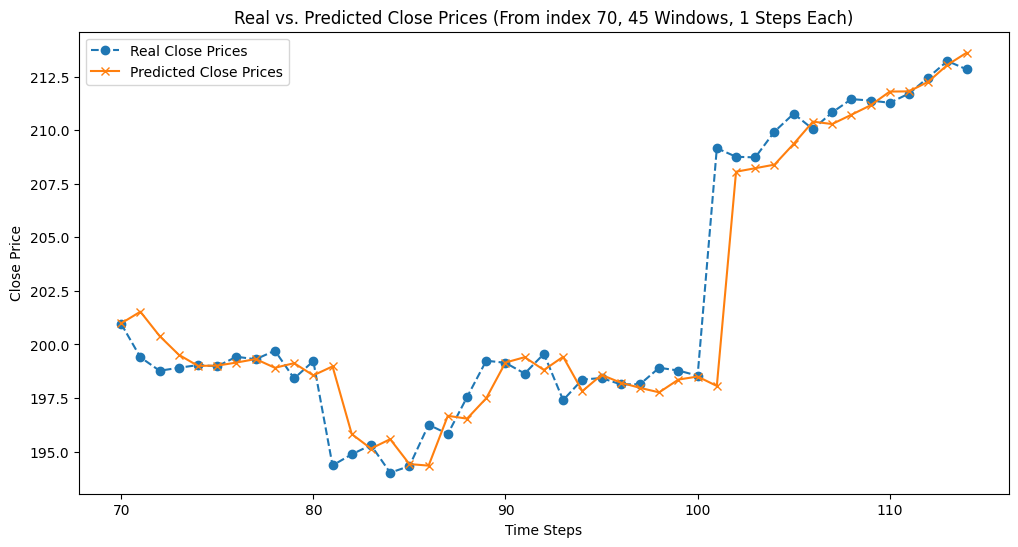

In [34]:

# Evaluate and plot results
evaluate_model(
    trained_model,
    test_loader,
    scaler,
    feature_cols,
    target_col_idx,
    window_width=45,
    start_index=70,
    pred_length=1,
    device=device
)

Model Evaluation:
  - Mean Squared Error (MSE): 2.2543
  - Mean Absolute Error (MAE): 0.9829


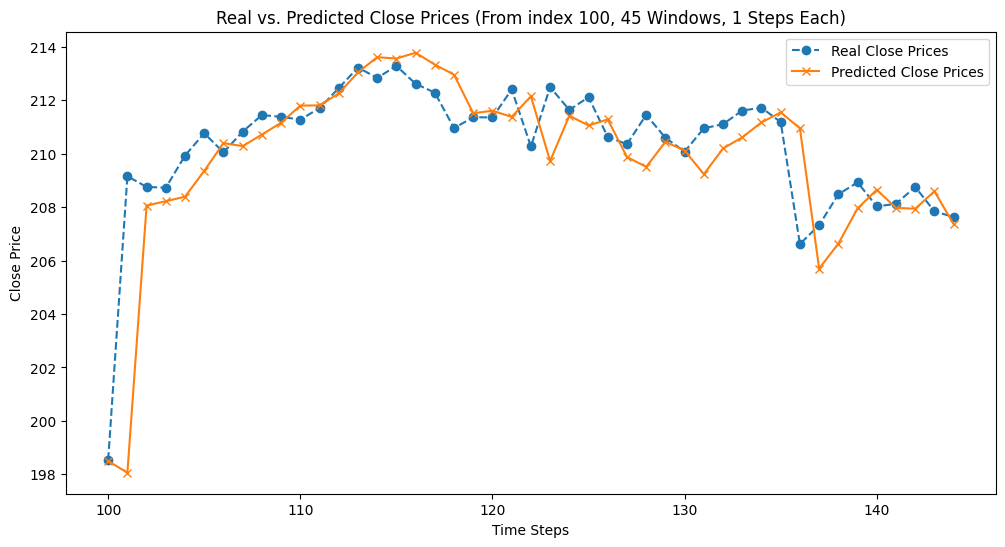

In [35]:

# Evaluate and plot results
evaluate_model(
    trained_model,
    test_loader,
    scaler,
    feature_cols,
    target_col_idx,
    window_width=45,
    start_index=100,
    pred_length=1,
    device=device
)